In [2]:
# Part 1: Setup and Imports

import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from src.config import *
from src.data.preprocessing import TextPreprocessor
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pickle
from typing import List, Dict, Any
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set style for plots
plt.style.use('seaborn')
sns.set_palette('Set2')

[nltk_data] Downloading package punkt to /Users/jyajuber/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jyajuber/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jyajuber/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/var/folders/p0/q_mndv194n5crjn25nk4hz_80000gn/T/ipykernel_6241/2350424359.py:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
# Load data
df = pd.read_csv(RAW_DATA_DIR / 'youtoxic_english_1000_.csv')

# Display basic information
print("=== Dataset Overview ===")
print(f"Number of samples: {len(df)}")
print(f"\nShape: {df.shape}")
print("\nColumns:", df.columns.tolist())

print("\n=== Missing Values ===")
print(df.isnull().sum())

print("\n=== Sample Data ===")
display(df.head())

=== Dataset Overview ===
Number of samples: 1000

Shape: (1000, 15)

Columns: ['CommentId', 'VideoId', 'Text', 'IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']

=== Missing Values ===
CommentId          0
VideoId            0
Text               0
IsToxic            0
IsAbusive          0
IsThreat           0
IsProvocative      0
IsObscene          0
IsHatespeech       0
IsRacist           0
IsNationalist      0
IsSexist           0
IsHomophobic       0
IsReligiousHate    0
IsRadicalism       0
dtype: int64

=== Sample Data ===


CommentId      VideoId   
0  Ugg2KwwX0V8-aXgCoAEC  04kJtp6pVXI  \
1  Ugg2s5AzSPioEXgCoAEC  04kJtp6pVXI   
2  Ugg3dWTOxryFfHgCoAEC  04kJtp6pVXI   
3  Ugg7Gd006w1MPngCoAEC  04kJtp6pVXI   
4  Ugg8FfTbbNF8IngCoAEC  04kJtp6pVXI   

                                                Text  IsToxic  IsAbusive   
0  If only people would just take a step back and...    False      False  \
1  Law enforcement is not trained to shoot to app...     True       True   
2  \nDont you reckon them 'black lives matter' ba...     True       True   
3  There are a very large number of people who do...    False      False   
4  The Arab dude is absolutely right, he should h...    False      False   

   IsThreat  IsProvocative  IsObscene  IsHatespeech  IsRacist  IsNationalist   
0     False          False      False         False     False          False  \
1     False          False      False         False     False          False   
2     False          False       True         False     False          False   
3     False          False      False         False     False          False   
4     False          False      False         False     False          False   

   IsSexist  IsHomophobic  IsReligiousHate  IsRadicalism  
0     False         False            False         False  
1     False         False            False         False  
2     False         False            False         False  
3     False         False            False         False  
4     False         False            False         False

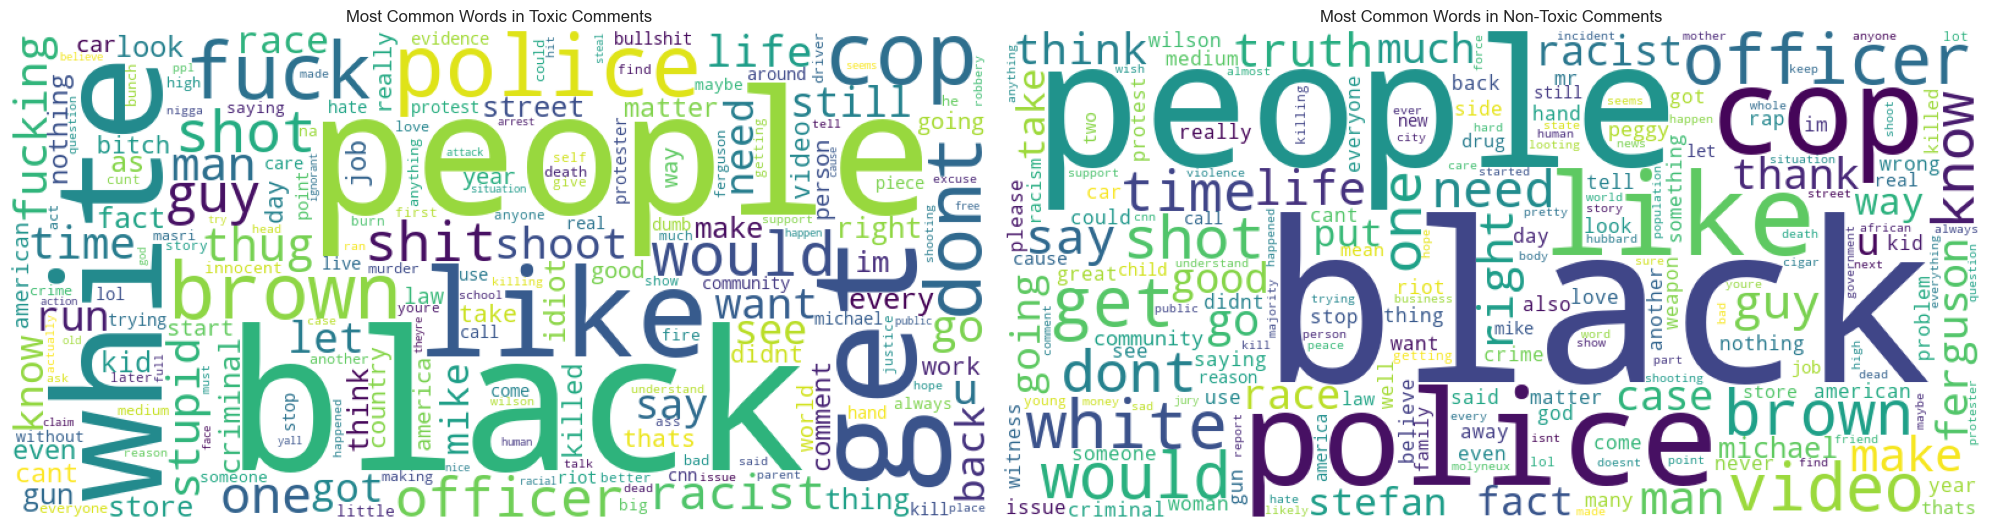

In [4]:
# Part 2: Word Frequency Analysis and Text Patterns

# Initialize preprocessor
preprocessor = TextPreprocessor()

# Process texts
df['processed_text'] = df['Text'].apply(preprocessor.clean_text)

# Separate toxic and non-toxic comments
toxic_mask = df[TOXIC_CATEGORIES].any(axis=1)
toxic_texts = df[toxic_mask]['processed_text']
non_toxic_texts = df[~toxic_mask]['processed_text']

# Function to get word frequencies
def get_word_frequencies(texts):
    words = ' '.join(texts).split()
    return Counter(words)

# Get word frequencies
toxic_words = get_word_frequencies(toxic_texts)
non_toxic_words = get_word_frequencies(non_toxic_texts)

# Create word clouds
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
wordcloud_toxic = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(toxic_words)
plt.imshow(wordcloud_toxic)
plt.title('Most Common Words in Toxic Comments')
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_nontoxic = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(non_toxic_words)
plt.imshow(wordcloud_nontoxic)
plt.title('Most Common Words in Non-Toxic Comments')
plt.axis('off')

plt.tight_layout()
plt.show()

=== Top Words in Toxic Comments ===


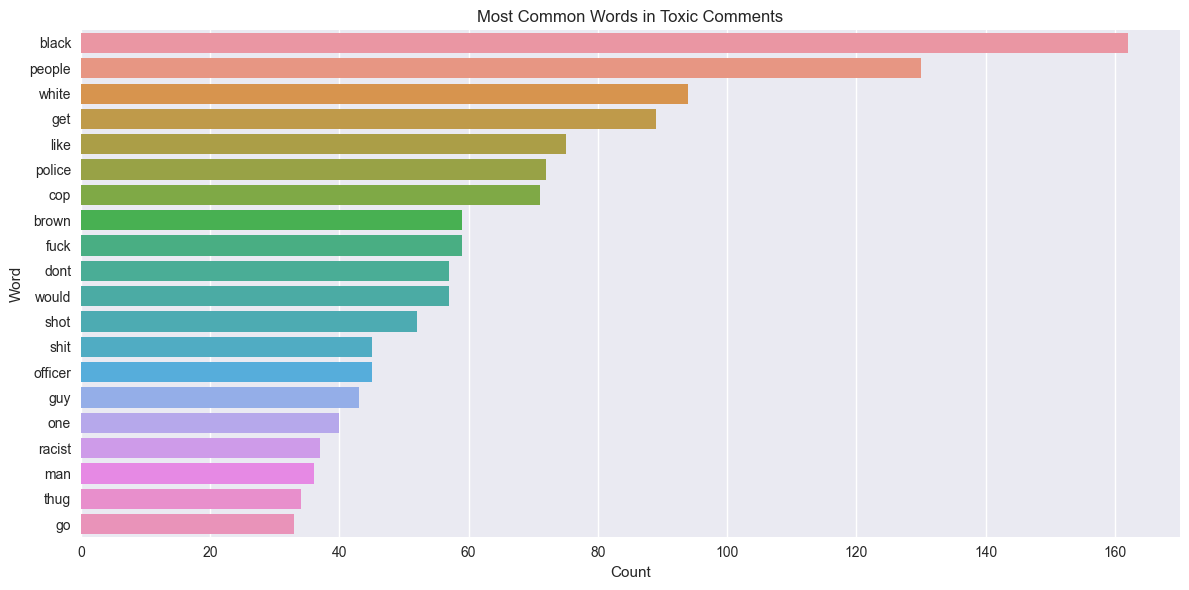

Word  Count
0     black    162
1    people    130
2     white     94
3       get     89
4      like     75
5    police     72
6       cop     71
7     brown     59
8      fuck     59
9      dont     57
10    would     57
11     shot     52
12     shit     45
13  officer     45
14      guy     43
15      one     40
16   racist     37
17      man     36
18     thug     34
19       go     33


=== Top Words in Non-Toxic Comments ===


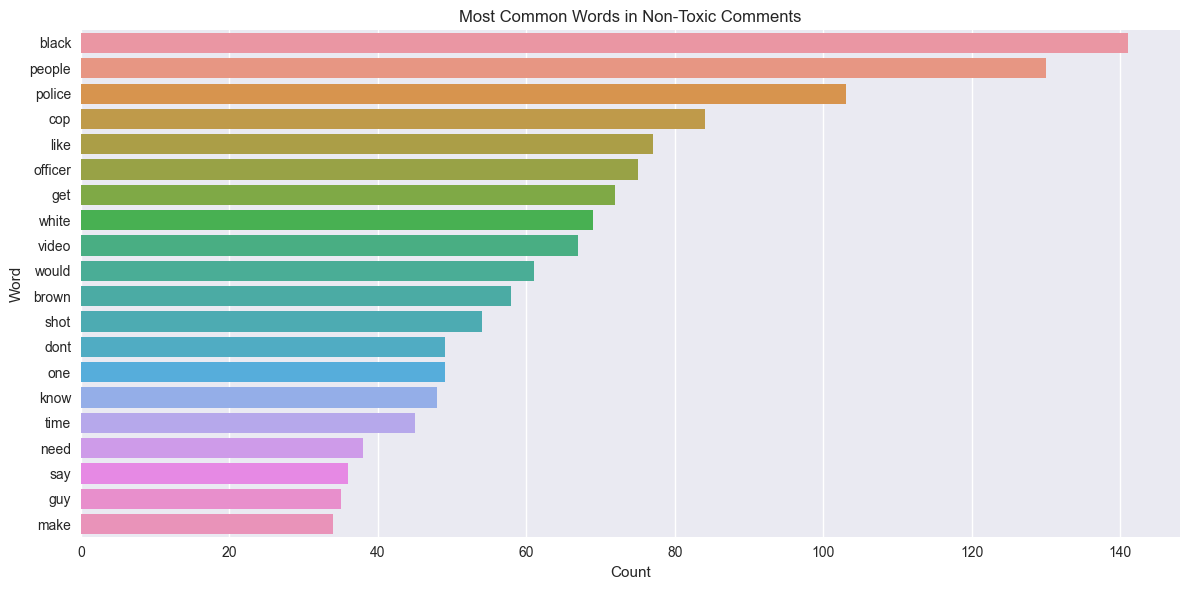

Word  Count
0     black    141
1    people    130
2    police    103
3       cop     84
4      like     77
5   officer     75
6       get     72
7     white     69
8     video     67
9     would     61
10    brown     58
11     shot     54
12     dont     49
13      one     49
14     know     48
15     time     45
16     need     38
17      say     36
18      guy     35
19     make     34

In [5]:
# Display top words statistics
def plot_top_words(word_counter, title, n=20):
    words = pd.DataFrame(word_counter.most_common(n), columns=['Word', 'Count'])
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=words, x='Count', y='Word')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    return words

print("=== Top Words in Toxic Comments ===")
toxic_top_words = plot_top_words(toxic_words, 'Most Common Words in Toxic Comments')
display(toxic_top_words)

print("\n=== Top Words in Non-Toxic Comments ===")
non_toxic_top_words = plot_top_words(non_toxic_words, 'Most Common Words in Non-Toxic Comments')
display(non_toxic_top_words)


=== Most Common Words in IsToxic Comments ===


Word  Count
0     black    162
1    people    130
2     white     94
3       get     89
4      like     75
5    police     72
6       cop     71
7     brown     59
8      fuck     59
9      dont     57
10    would     57
11     shot     52
12     shit     45
13  officer     45
14      guy     43

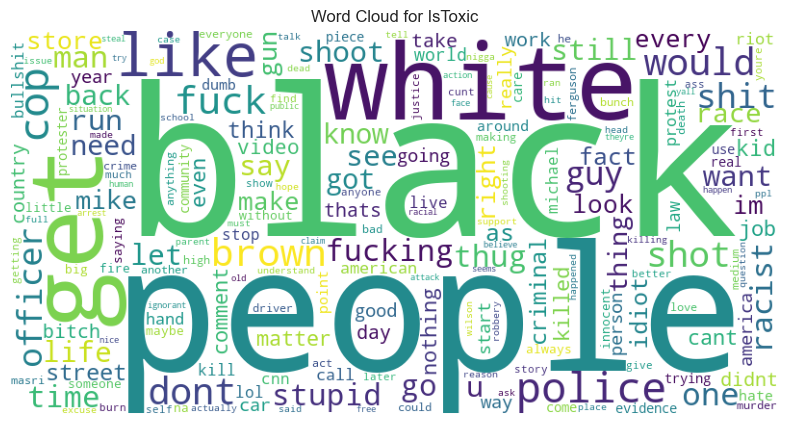


Statistics for IsToxic:
Total comments: 462
Percentage of all comments: 46.20%

=== Most Common Words in IsAbusive Comments ===


Word  Count
0     black     80
1    people     77
2       get     69
3    police     60
4       cop     59
5      fuck     56
6     brown     42
7      dont     41
8      shit     39
9      like     38
10    would     37
11      guy     37
12     shot     37
13  fucking     32
14    white     30

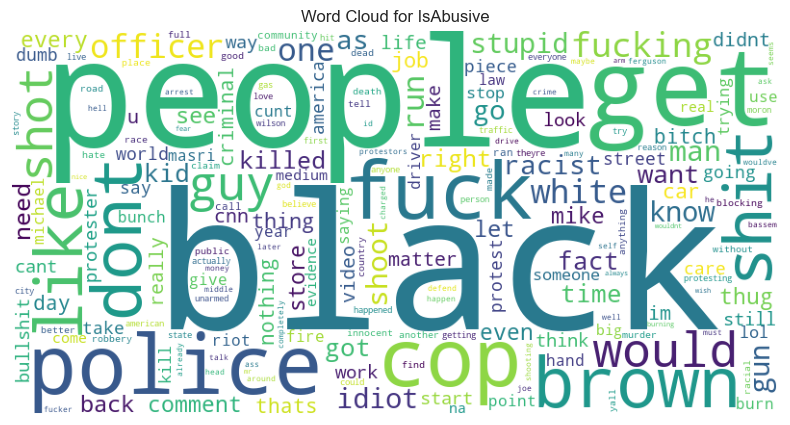


Statistics for IsAbusive:
Total comments: 353
Percentage of all comments: 35.30%

=== Most Common Words in IsThreat Comments ===


Word  Count
0         get      7
1        kill      4
2         cop      4
3        need      4
4      driver      4
5        shit      3
6   protester      3
7         ran      3
8       would      3
9      police      2
10         id      2
11       time      2
12         as      2
13       even      2
14       back      2

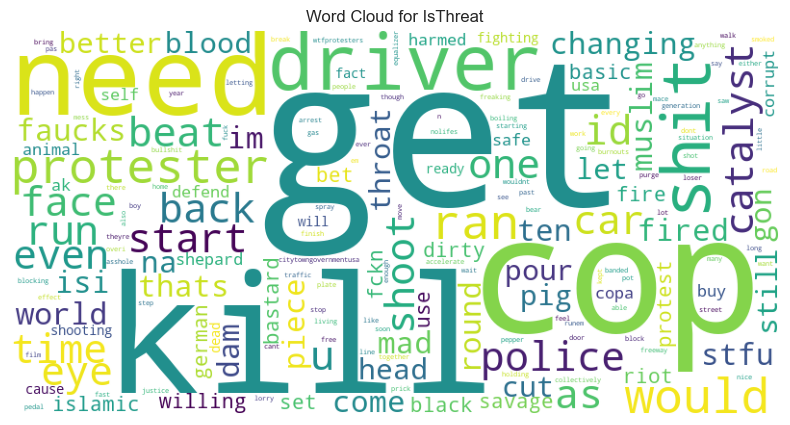


Statistics for IsThreat:
Total comments: 21
Percentage of all comments: 2.10%

=== Most Common Words in IsProvocative Comments ===


Word  Count
0    black     45
1   people     43
2   police     37
3      cop     33
4      get     32
5      run     24
6     fuck     22
7     shot     20
8    would     18
9    brown     15
10   shoot     15
11   white     15
12    like     14
13     one     14
14   right     13

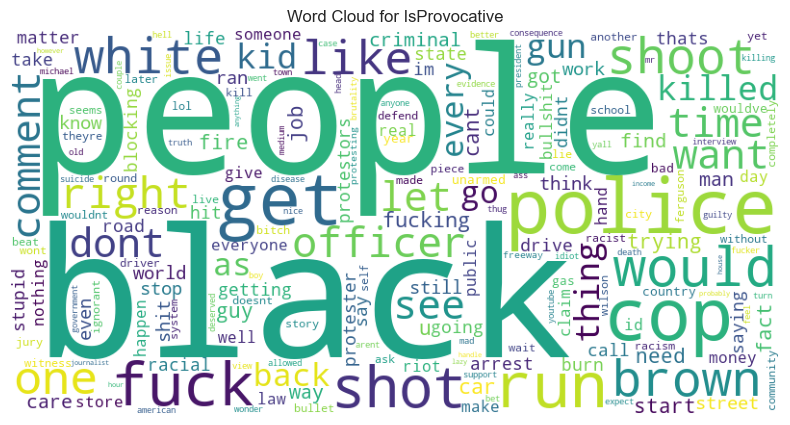


Statistics for IsProvocative:
Total comments: 161
Percentage of all comments: 16.10%

=== Most Common Words in IsObscene Comments ===


Word  Count
0     black     52
1      fuck     40
2    people     35
3      shit     30
4       cop     22
5       get     22
6      dont     21
7    police     21
8   fucking     21
9      like     19
10    white     17
11    brown     16
12       as     16
13      guy     15
14  officer     15

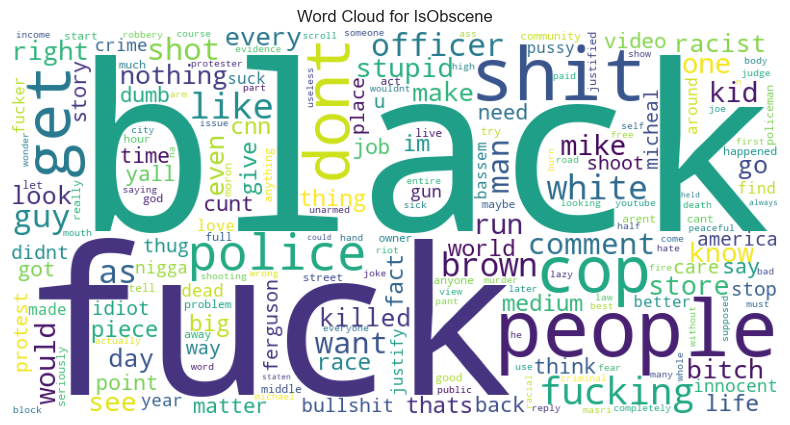


Statistics for IsObscene:
Total comments: 100
Percentage of all comments: 10.00%

=== Most Common Words in IsHatespeech Comments ===


Word  Count
0    black    110
1   people     73
2    white     72
3     like     49
4      get     30
5    would     28
6    brown     27
7     thug     25
8     dont     22
9     shot     20
10    race     19
11     cop     18
12     say     18
13    life     18
14  racist     17

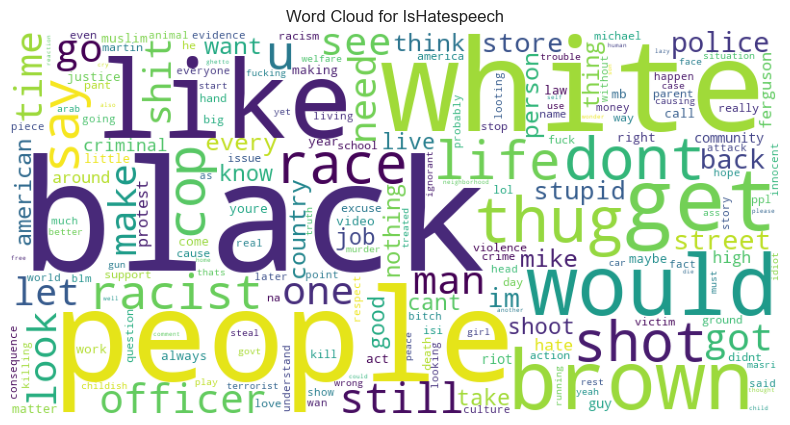


Statistics for IsHatespeech:
Total comments: 138
Percentage of all comments: 13.80%

=== Most Common Words in IsRacist Comments ===


Word  Count
0    black    108
1    white     71
2   people     70
3     like     49
4      get     30
5    would     27
6    brown     27
7     thug     25
8     dont     21
9     shot     20
10    race     19
11    life     18
12     cop     17
13       u     17
14     say     17

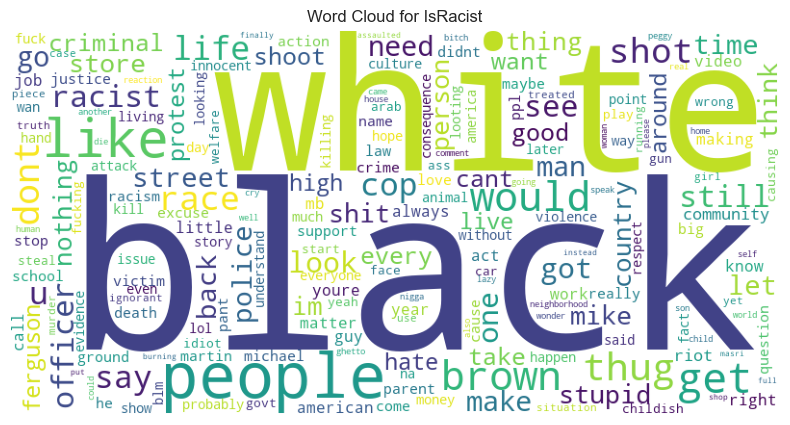


Statistics for IsRacist:
Total comments: 125
Percentage of all comments: 12.50%

=== Most Common Words in IsNationalist Comments ===


Word  Count
0     people      4
1        usa      2
2      earth      2
3   american      2
4       hate      2
5      black      2
6          u      2
7      would      2
8     stupid      2
9       land      1
10      free      1
11      baby      1
12  hahahaha      1
13    living      1
14  thankful      1

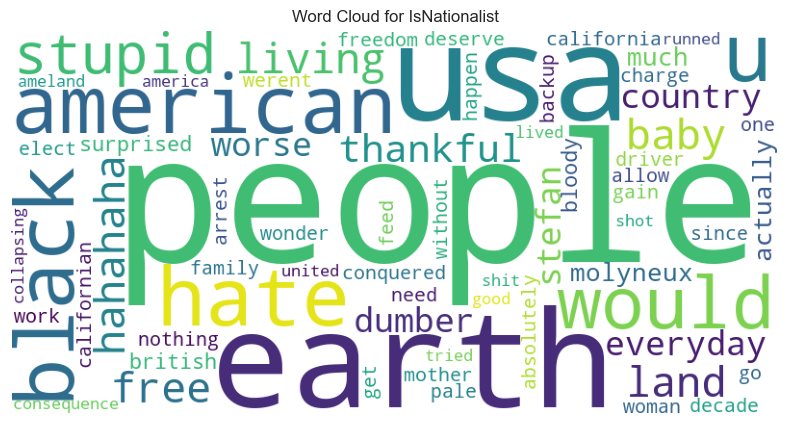


Statistics for IsNationalist:
Total comments: 8
Percentage of all comments: 0.80%

=== Most Common Words in IsSexist Comments ===


Word  Count
0             n      2
1          anna      1
2          dumb      1
3            as      1
4           joe      1
5         rogan      1
6          clue      1
7    sayinganna      1
8            go      1
9          porn      1
10    something      1
11        leave      1
12          job      1
13          one      1
14  intelligent      1

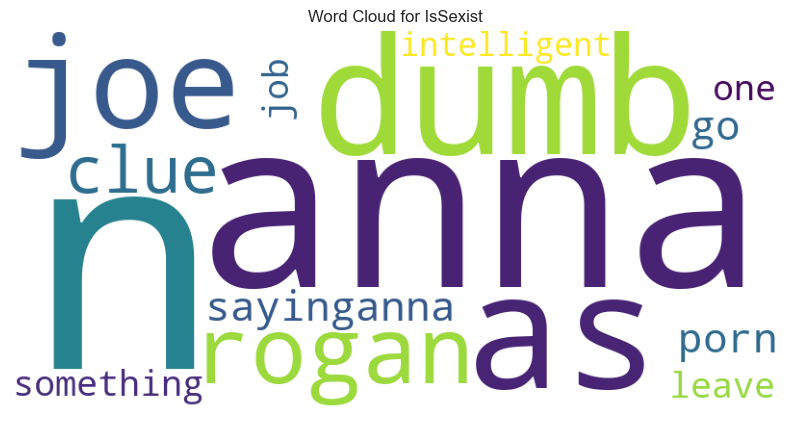


Statistics for IsSexist:
Total comments: 1
Percentage of all comments: 0.10%

=== No entries found for category: IsHomophobic ===

Statistics for IsHomophobic:
Total comments: 0
Percentage of all comments: 0.00%

=== Most Common Words in IsReligiousHate Comments ===


Word  Count
0      muslim      7
1      people      5
2         isi      4
3        shit      4
4        time      4
5       still      4
6        shot      4
7   terrorist      3
8        head      3
9          im      3
10       like      3
11    islamic      3
12  extremist      2
13        cut      2
14        say      2

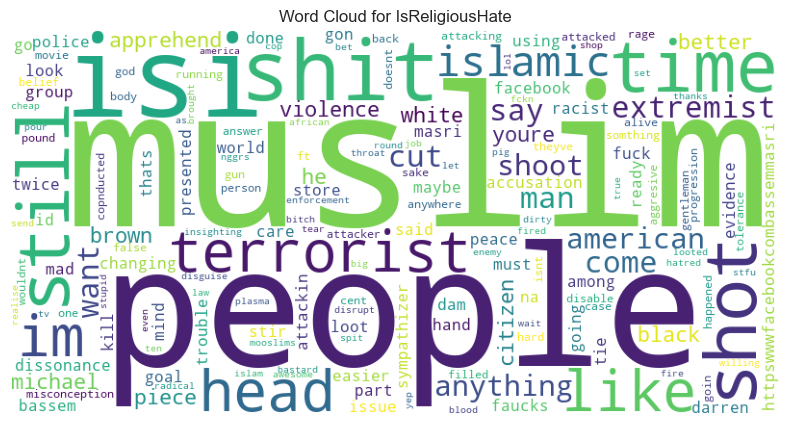


Statistics for IsReligiousHate:
Total comments: 12
Percentage of all comments: 1.20%

=== No entries found for category: IsRadicalism ===

Statistics for IsRadicalism:
Total comments: 0
Percentage of all comments: 0.00%


In [6]:
# Analyze word patterns by category
for category in TOXIC_CATEGORIES:
    # Get texts for this category
    category_texts = df[df[category]]['processed_text']
    
    # Check if we have any texts for this category
    if len(category_texts) > 0:
        category_words = get_word_frequencies(category_texts)
        
        if len(category_words) > 0:  # Check if we have any words
            print(f"\n=== Most Common Words in {category} Comments ===")
            words_df = pd.DataFrame(category_words.most_common(15), columns=['Word', 'Count'])
            display(words_df)
            
            # Plot word cloud
            plt.figure(figsize=(10, 5))
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(category_words)
            plt.imshow(wordcloud)
            plt.title(f'Word Cloud for {category}')
            plt.axis('off')
            plt.show()
        else:
            print(f"\n=== No words found in {category} Comments after processing ===")
    else:
        print(f"\n=== No entries found for category: {category} ===")
        
    # Print basic statistics
    total_comments = len(df)
    category_comments = len(category_texts)
    print(f"\nStatistics for {category}:")
    print(f"Total comments: {category_comments}")
    print(f"Percentage of all comments: {(category_comments/total_comments)*100:.2f}%")

=== Label Distribution ===


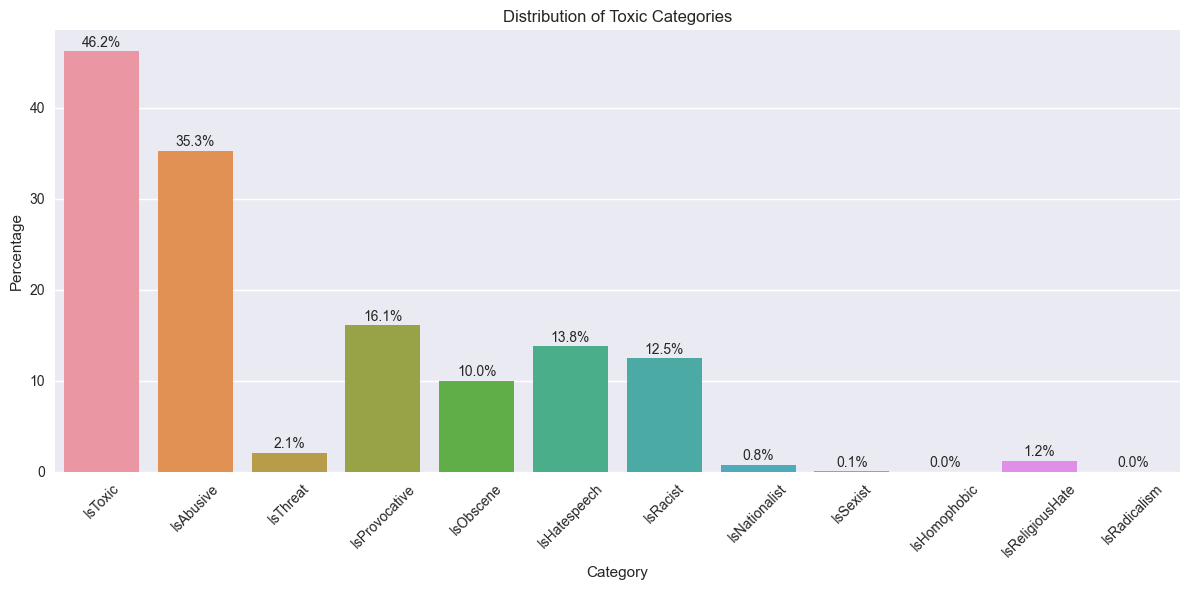

Category  Count  Percentage
IsToxic                  IsToxic    462        46.2
IsAbusive              IsAbusive    353        35.3
IsThreat                IsThreat     21         2.1
IsProvocative      IsProvocative    161        16.1
IsObscene              IsObscene    100        10.0
IsHatespeech        IsHatespeech    138        13.8
IsRacist                IsRacist    125        12.5
IsNationalist      IsNationalist      8         0.8
IsSexist                IsSexist      1         0.1
IsHomophobic        IsHomophobic      0         0.0
IsReligiousHate  IsReligiousHate     12         1.2
IsRadicalism        IsRadicalism      0         0.0

In [7]:
# Part 3: Label Distribution Analysis

def plot_label_distribution(df, toxic_categories):
    """Plot distribution of toxic labels"""
    # Calculate percentages
    percentages = df[toxic_categories].mean() * 100
    
    # Create bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x=percentages.index, y=percentages.values)
    plt.title('Distribution of Toxic Categories')
    plt.xlabel('Category')
    plt.ylabel('Percentage')
    plt.xticks(rotation=45)
    
    # Add percentage labels
    for i, v in enumerate(percentages):
        plt.text(i, v + 0.5, f'{v:.1f}%', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    return percentages

print("=== Label Distribution ===")
label_stats = plot_label_distribution(df, TOXIC_CATEGORIES)
display(pd.DataFrame({
    'Category': TOXIC_CATEGORIES,
    'Count': df[TOXIC_CATEGORIES].sum(),
    'Percentage': label_stats
}))

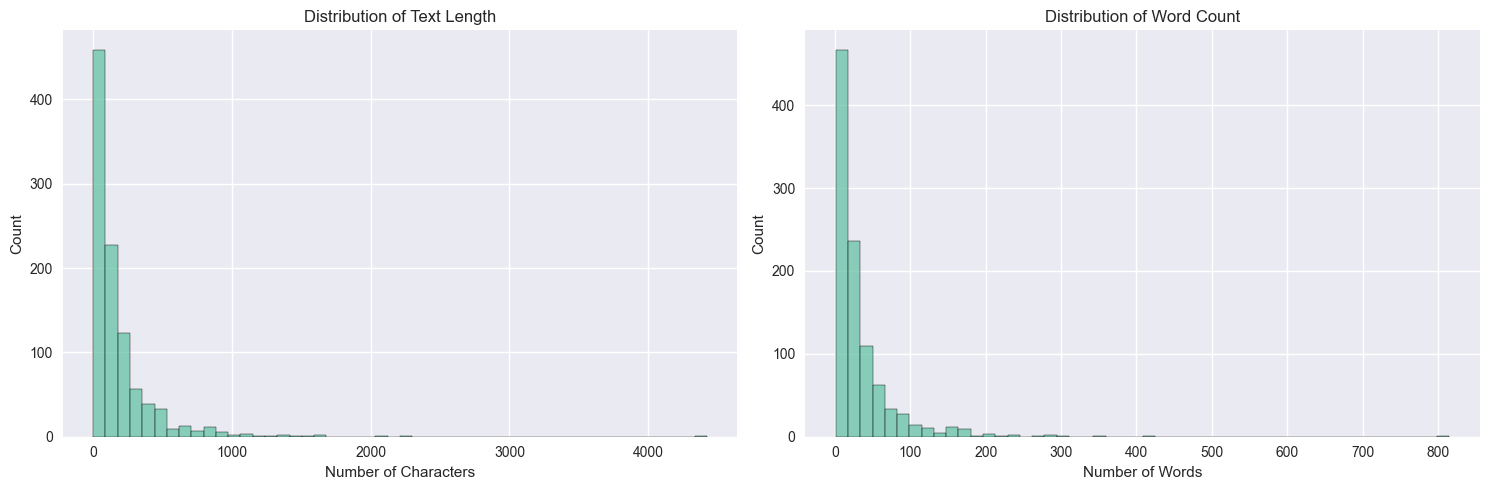


=== Text Statistics ===

Text Length Statistics:
count    1000.000000
mean      185.522000
std       270.786589
min         3.000000
25%        47.000000
50%       101.000000
75%       217.000000
max      4421.000000
Name: text_length, dtype: float64

Word Count Statistics:
count    1000.000000
mean       33.776000
std        49.069498
min         1.000000
25%         9.000000
50%        19.000000
75%        39.000000
max       815.000000
Name: word_count, dtype: float64


In [8]:
# Part 4: Text Analysis (length, word count)

# Add text length features if not already added
if 'text_length' not in df.columns:
    df['text_length'] = df['Text'].str.len()
if 'word_count' not in df.columns:
    df['word_count'] = df['Text'].str.split().str.len()

# Plot distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df, x='text_length', bins=50, ax=ax1)
ax1.set_title('Distribution of Text Length')
ax1.set_xlabel('Number of Characters')

sns.histplot(data=df, x='word_count', bins=50, ax=ax2)
ax2.set_title('Distribution of Word Count')
ax2.set_xlabel('Number of Words')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Text Statistics ===")
print("\nText Length Statistics:")
print(df['text_length'].describe())
print("\nWord Count Statistics:")
print(df['word_count'].describe())

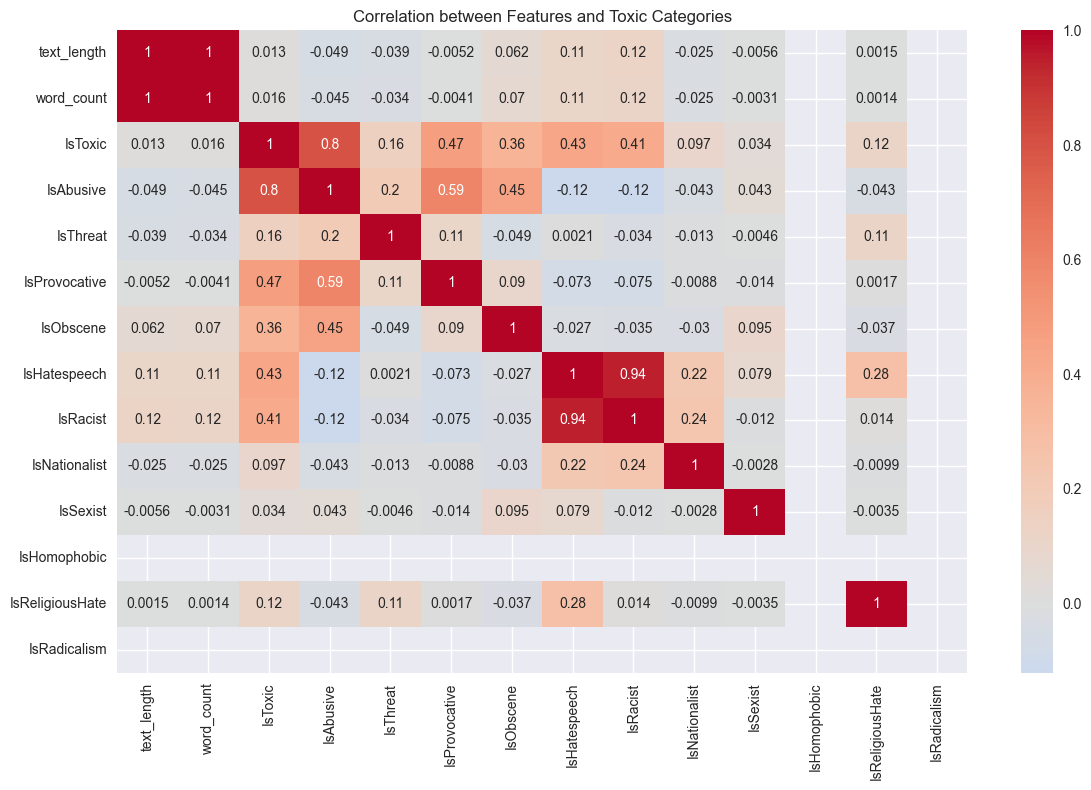


=== Strongest Feature-Label Correlations ===

text_length:
  IsRacist: 0.121
  IsHatespeech: 0.110
  IsObscene: 0.062

word_count:
  IsRacist: 0.119
  IsHatespeech: 0.108
  IsObscene: 0.070


In [9]:
# Part 5: Correlation Analysis

# Calculate correlations between features and toxic categories
feature_cols = ['text_length', 'word_count']
correlation_matrix = df[feature_cols + TOXIC_CATEGORIES].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Features and Toxic Categories')
plt.tight_layout()
plt.show()

# Print strongest correlations
print("\n=== Strongest Feature-Label Correlations ===")
for feature in feature_cols:
    correlations = correlation_matrix.loc[feature, TOXIC_CATEGORIES]
    strongest = correlations.abs().nlargest(3)
    print(f"\n{feature}:")
    for cat, corr in strongest.items():
        print(f"  {cat}: {corr:.3f}")

In [10]:
# Part 6: Final Text Preprocessing and Feature Engineering

def additional_text_features(text):
    """Create additional text features based on patterns found in Part 2"""
    if not isinstance(text, str):
        return pd.Series({
            'caps_ratio': 0,
            'punct_ratio': 0,
            'avg_word_length': 0,
            'unique_words_ratio': 0
        })
    
    # Calculate features
    caps_ratio = sum(1 for c in text if c.isupper()) / len(text) if text else 0
    punct_ratio = sum(1 for c in text if c in '.,!?;:') / len(text) if text else 0
    
    words = text.split()
    avg_word_length = np.mean([len(word) for word in words]) if words else 0
    unique_words_ratio = len(set(words)) / len(words) if words else 0
    
    return pd.Series({
        'caps_ratio': caps_ratio,
        'punct_ratio': punct_ratio,
        'avg_word_length': avg_word_length,
        'unique_words_ratio': unique_words_ratio
    })

# Add additional features
print("Adding additional text features...")
additional_features = df['processed_text'].apply(additional_text_features)
df = pd.concat([df, additional_features], axis=1)

# Display sample of processed data
print("\n=== Sample of Processed Data ===")
display(df.head())

Adding additional text features...

=== Sample of Processed Data ===


CommentId      VideoId   
0  Ugg2KwwX0V8-aXgCoAEC  04kJtp6pVXI  \
1  Ugg2s5AzSPioEXgCoAEC  04kJtp6pVXI   
2  Ugg3dWTOxryFfHgCoAEC  04kJtp6pVXI   
3  Ugg7Gd006w1MPngCoAEC  04kJtp6pVXI   
4  Ugg8FfTbbNF8IngCoAEC  04kJtp6pVXI   

                                                Text  IsToxic  IsAbusive   
0  If only people would just take a step back and...    False      False  \
1  Law enforcement is not trained to shoot to app...     True       True   
2  \nDont you reckon them 'black lives matter' ba...     True       True   
3  There are a very large number of people who do...    False      False   
4  The Arab dude is absolutely right, he should h...    False      False   

   IsThreat  IsProvocative  IsObscene  IsHatespeech  IsRacist  ...   
0     False          False      False         False     False  ...  \
1     False          False      False         False     False  ...   
2     False          False       True         False     False  ...   
3     False          False      False         False     False  ...   
4     False          False      False         False     False  ...   

   IsHomophobic  IsReligiousHate  IsRadicalism   
0         False            False         False  \
1         False            False         False   
2         False            False         False   
3         False            False         False   
4         False            False         False   

                                      processed_text  text_length word_count   
0  people would take step back make case wasnt an...         1558        287  \
1  law enforcement trained shoot apprehend traine...          138         25   
2  dont reckon black life matter banner held whit...          420         77   
3  large number people like police officer called...          582        107   
4  arab dude absolutely right shot extra time sho...          243         47   

   caps_ratio  punct_ratio  avg_word_length  unique_words_ratio  
0         0.0          0.0         5.596899            0.837209  
1         0.0          0.0         6.000000            0.846154  
2         0.0          0.0         5.325000            0.925000  
3         0.0          0.0         5.938776            0.714286  
4         0.0          0.0         5.043478            0.782609  

[5 rows x 22 columns]

In [11]:
# Part 7: Save Processed Data

# Save the enhanced dataset
output_path = PROCESSED_DATA_DIR / 'processed_data.pkl'
df.to_pickle(output_path)

# Save important statistics and analysis results
analysis_results = {
    'label_distribution': label_stats.to_dict(),
    'text_stats': {
        'length': df['text_length'].describe().to_dict(),
        'word_count': df['word_count'].describe().to_dict()
    },
    'correlations': correlation_matrix.to_dict(),
    'additional_features': {
        col: df[col].describe().to_dict() 
        for col in ['caps_ratio', 'punct_ratio', 'avg_word_length', 'unique_words_ratio']
    }
}

with open(PROCESSED_DATA_DIR / 'analysis_results.pkl', 'wb') as f:
    pickle.dump(analysis_results, f)

print("Data and analysis results saved successfully!")

Data and analysis results saved successfully!


=== Class Imbalance Analysis ===


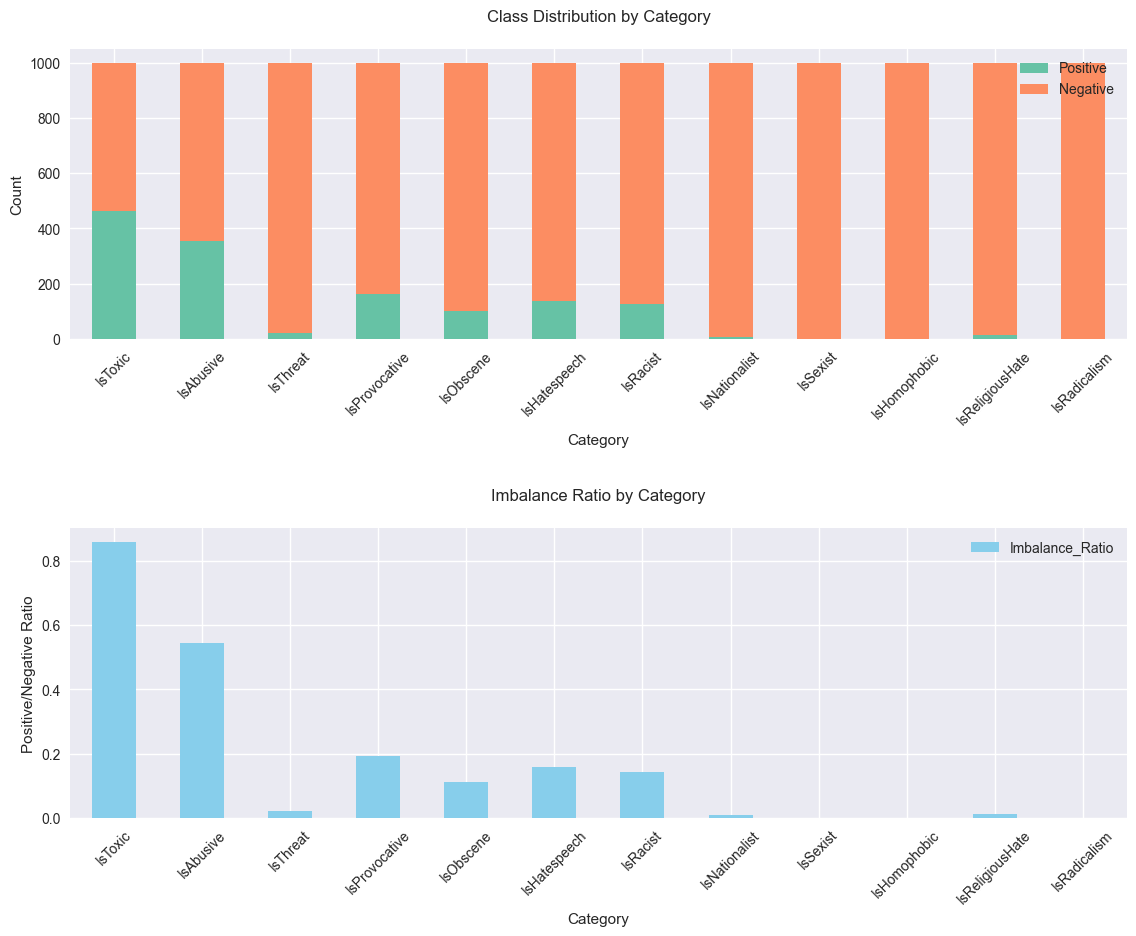


=== Imbalance Statistics ===


Category  Positive  Negative  Imbalance_Ratio  Minority_Percentage
0           IsToxic       462       538         0.858736                 46.2
1         IsAbusive       353       647         0.545595                 35.3
2          IsThreat        21       979         0.021450                  2.1
3     IsProvocative       161       839         0.191895                 16.1
4         IsObscene       100       900         0.111111                 10.0
5      IsHatespeech       138       862         0.160093                 13.8
6          IsRacist       125       875         0.142857                 12.5
7     IsNationalist         8       992         0.008065                  0.8
8          IsSexist         1       999         0.001001                  0.1
9      IsHomophobic         0      1000         0.000000                  0.0
10  IsReligiousHate        12       988         0.012146                  1.2
11     IsRadicalism         0      1000         0.000000                  0.0

In [15]:
def analyze_class_imbalance(df, toxic_categories):
    """Analyze and visualize class imbalance in detail"""
    print("=== Class Imbalance Analysis ===")
    
    # Calculate imbalance ratios
    imbalance_stats = []
    
    for category in toxic_categories:
        positive = df[category].sum()
        negative = len(df) - positive
        ratio = positive/negative
        
        imbalance_stats.append({
            'Category': category,
            'Positive': positive,
            'Negative': negative,
            'Imbalance_Ratio': ratio,
            'Minority_Percentage': min(positive, negative) / len(df) * 100
        })
    
    # Create DataFrame
    imbalance_df = pd.DataFrame(imbalance_stats)
    
    # Create figure with more height and proper spacing
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[1, 1])
    
    # Stacked bar plot
    imbalance_df.plot(x='Category', y=['Positive', 'Negative'], 
                     kind='bar', stacked=True, ax=ax1)
    ax1.set_title('Class Distribution by Category', pad=20)
    ax1.set_xlabel('Category')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)
    
    # Imbalance ratio plot using the same style
    imbalance_df.plot(x='Category', y='Imbalance_Ratio', 
                     kind='bar', ax=ax2, color='skyblue')
    ax2.set_title('Imbalance Ratio by Category', pad=20)
    ax2.set_xlabel('Category')
    ax2.set_ylabel('Positive/Negative Ratio')
    ax2.tick_params(axis='x', rotation=45)
    
    # Adjust layout to prevent overlap
    plt.tight_layout(pad=3.0)
    plt.show()
    
    print("\n=== Imbalance Statistics ===")
    display(imbalance_df)
    
    return imbalance_df

# Define toxic categories if not already defined
TOXIC_CATEGORIES = [
    'IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative',
    'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist',
    'IsSexist', 'IsHomophobic', 'IsReligiousHate', 'IsRadicalism'
]

# Run the analysis
imbalance_stats = analyze_class_imbalance(df, TOXIC_CATEGORIES)

=== Text Characteristics Analysis ===


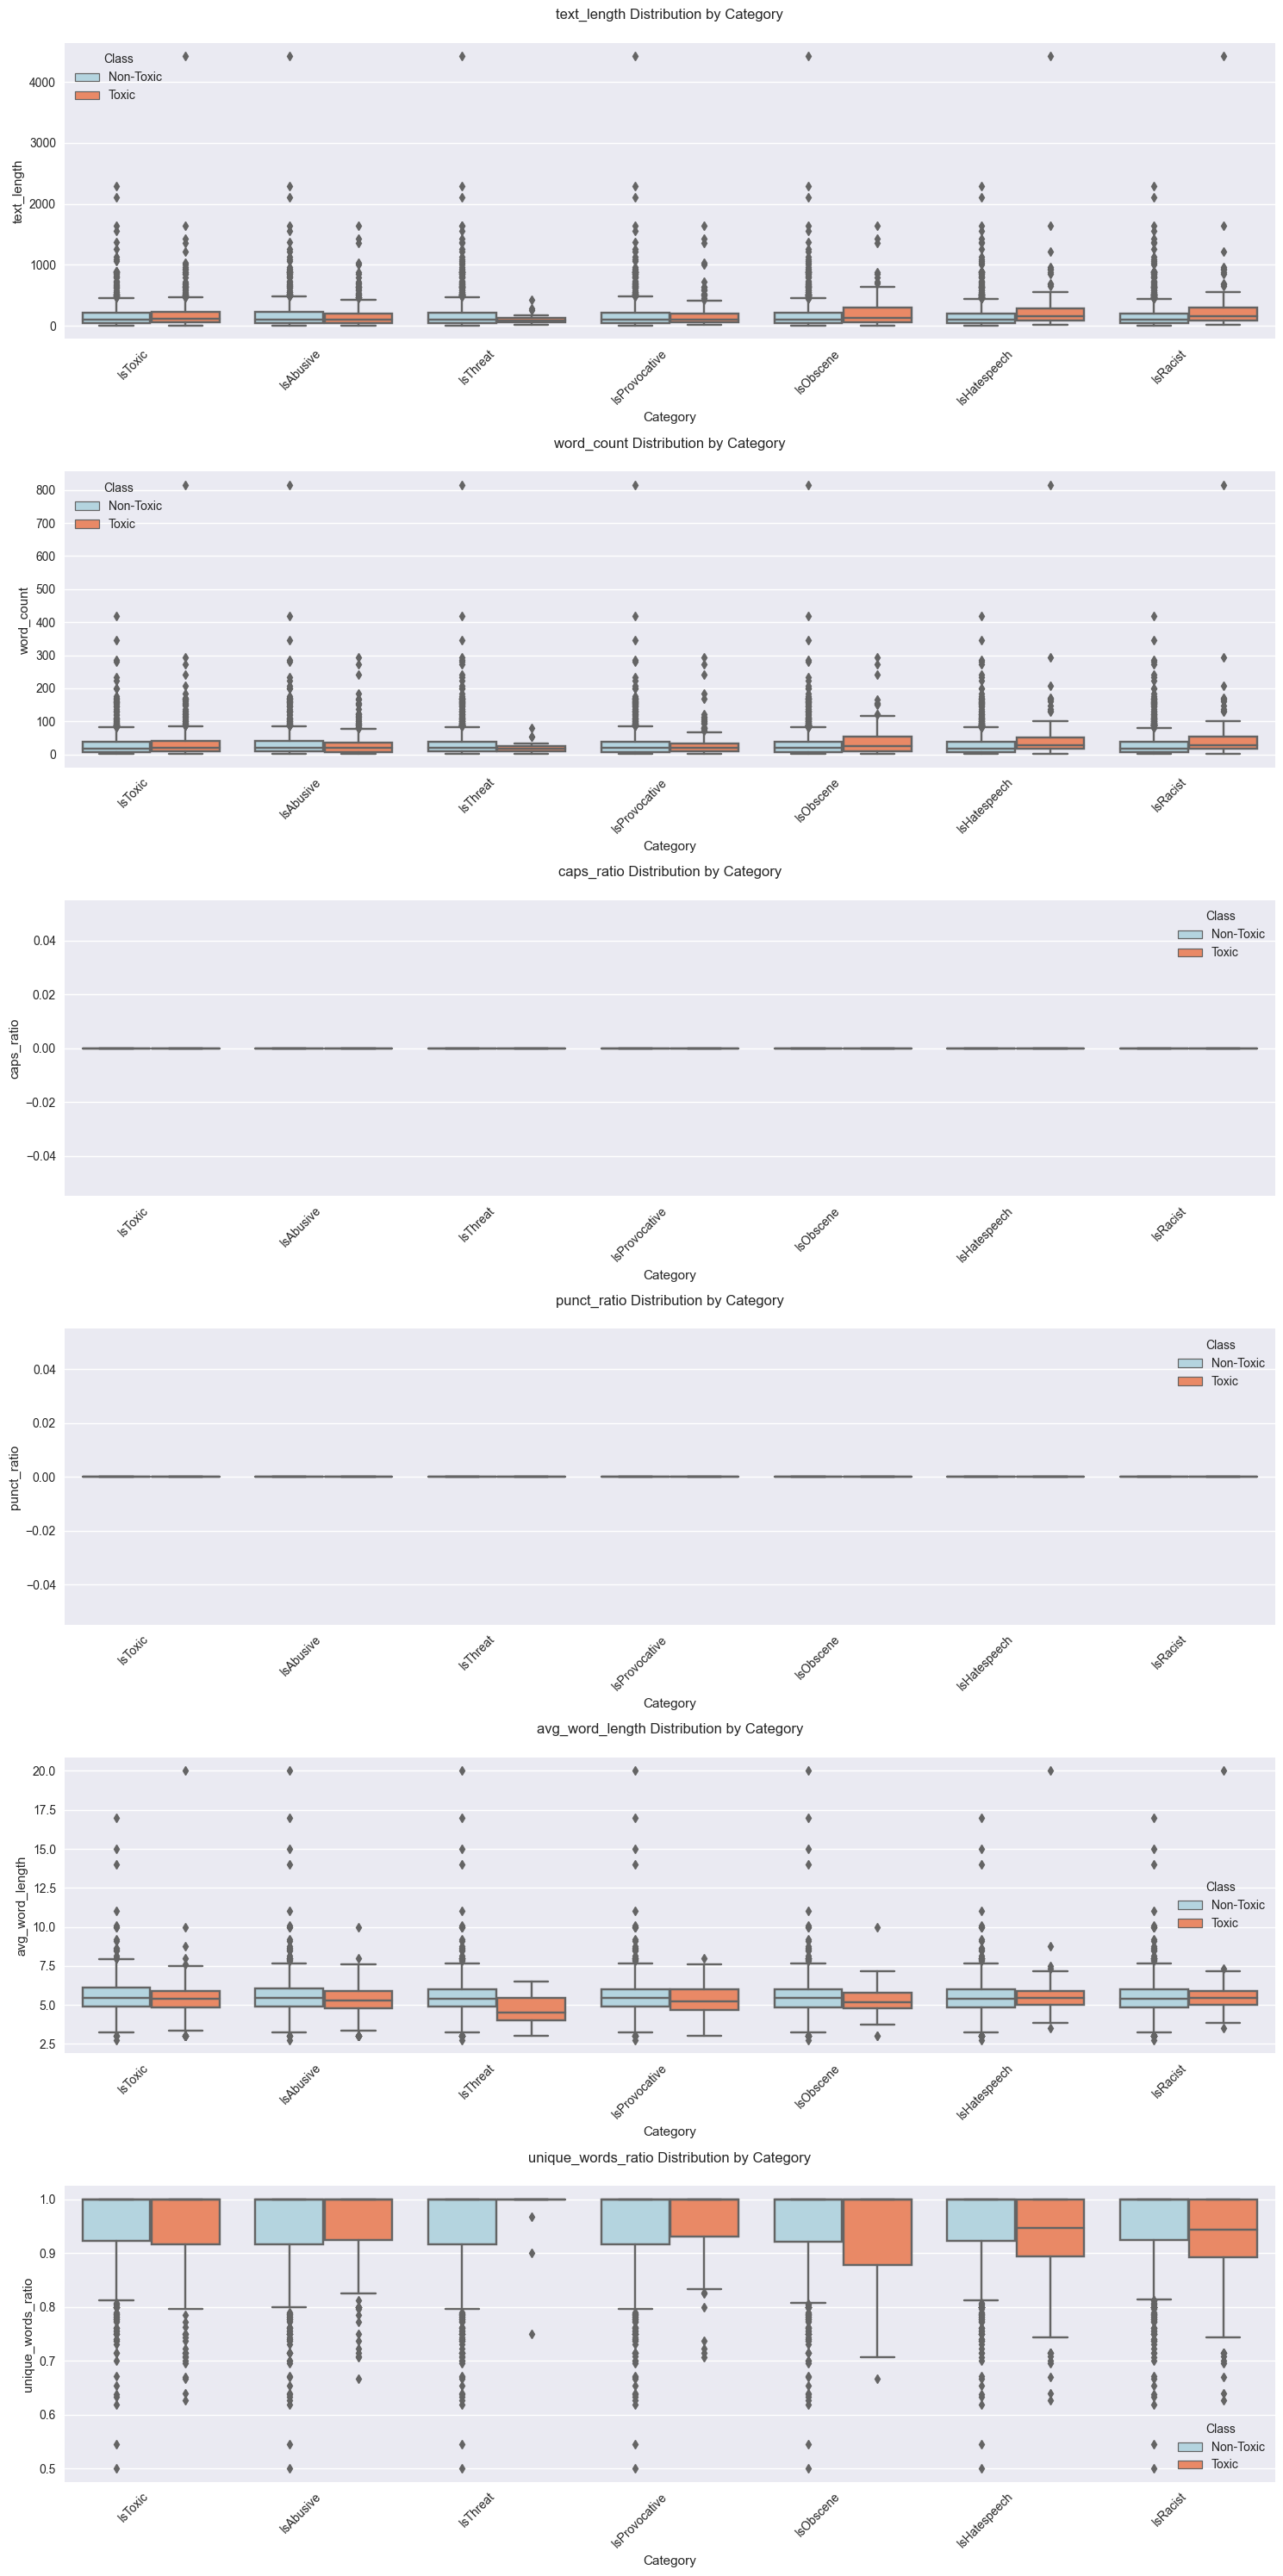


=== Feature Statistics by Category ===

TEXT_LENGTH

IsToxic:
Positive samples: Mean = 189.35, Std = 291.07
Negative samples: Mean = 182.23, Std = 252.30

IsAbusive:
Positive samples: Mean = 167.53, Std = 207.77
Negative samples: Mean = 195.34, Std = 299.33

IsThreat:
Positive samples: Mean = 113.57, Std = 100.14
Negative samples: Mean = 187.07, Std = 273.10

IsProvocative:
Positive samples: Mean = 182.30, Std = 249.42
Negative samples: Mean = 186.14, Std = 274.83

IsObscene:
Positive samples: Mean = 236.04, Std = 295.19
Negative samples: Mean = 179.91, Std = 267.53

IsHatespeech:
Positive samples: Mean = 259.93, Std = 433.24
Negative samples: Mean = 173.61, Std = 232.77

IsRacist:
Positive samples: Mean = 272.10, Std = 452.30
Negative samples: Mean = 173.15, Std = 231.44

WORD_COUNT

IsToxic:
Positive samples: Mean = 34.60, Std = 53.29
Negative samples: Mean = 33.07, Std = 45.17

IsAbusive:
Positive samples: Mean = 30.81, Std = 38.08
Negative samples: Mean = 35.39, Std = 54.09

IsThr

In [16]:
# Part 9: Text Characteristics by Category

def analyze_text_characteristics(df, toxic_categories):
    """
    Analyze text characteristics for each category with proper data reshaping
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing text features and category labels
    toxic_categories : list
        List of toxic category columns
    """
    print("=== Text Characteristics Analysis ===")
    
    # Setup the features to analyze
    text_features = ['text_length', 'word_count', 'caps_ratio', 
                    'punct_ratio', 'avg_word_length', 'unique_words_ratio']
    
    # Create figure for box plots
    fig, axes = plt.subplots(len(text_features), 1, 
                            figsize=(15, 5*len(text_features)))
    
    # Handle case of single feature
    if len(text_features) == 1:
        axes = [axes]
    
    feature_stats = {}
    
    # Analyze each feature
    for i, feature in enumerate(text_features):
        feature_stats[feature] = {}
        
        # Create data for plotting
        plot_data = []
        for category in toxic_categories:
            # Create temporary dataframe for this category
            temp_df = pd.DataFrame({
                'Feature': df[feature],
                'Category': category,
                'Label': df[category].map({True: 'Toxic', False: 'Non-Toxic'})
            })
            plot_data.append(temp_df)
        
        # Combine all data for this feature
        plot_df = pd.concat(plot_data, ignore_index=True)
        
        # Create box plot
        sns.boxplot(data=plot_df, x='Category', y='Feature', 
                   hue='Label', ax=axes[i],
                   palette={'Toxic': 'coral', 'Non-Toxic': 'lightblue'})
        
        # Customize plot
        axes[i].set_title(f'{feature} Distribution by Category', pad=20)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
        axes[i].set_ylabel(feature)
        
        # Remove prefix from legend
        handles, labels = axes[i].get_legend_handles_labels()
        axes[i].legend(handles, labels, title='Class')
        
        # Calculate statistics
        for category in toxic_categories:
            # Get positive and negative samples
            positive_mask = df[category]
            negative_mask = ~df[category]
            
            positive_stats = df.loc[positive_mask, feature].describe()
            negative_stats = df.loc[negative_mask, feature].describe()
            
            feature_stats[feature][category] = {
                'positive': positive_stats.to_dict(),
                'negative': negative_stats.to_dict()
            }
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\n=== Feature Statistics by Category ===")
    for feature, stats in feature_stats.items():
        print(f"\n{feature.upper()}")
        for category, values in stats.items():
            print(f"\n{category}:")
            try:
                print(f"Positive samples: Mean = {values['positive']['mean']:.2f}, "
                      f"Std = {values['positive']['std']:.2f}")
                print(f"Negative samples: Mean = {values['negative']['mean']:.2f}, "
                      f"Std = {values['negative']['std']:.2f}")
            except KeyError:
                print("Warning: Missing statistics for this category")
    
    return feature_stats

# Define toxic categories
TOXIC_CATEGORIES = [
    'IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative',
    'IsObscene', 'IsHatespeech', 'IsRacist'
]

# Run the analysis
text_characteristics = analyze_text_characteristics(df, TOXIC_CATEGORIES)

/Users/jyajuber/Factoriaf5/Proyecto_NLP/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== Feature Importance Analysis ===

Analyzing IsToxic...


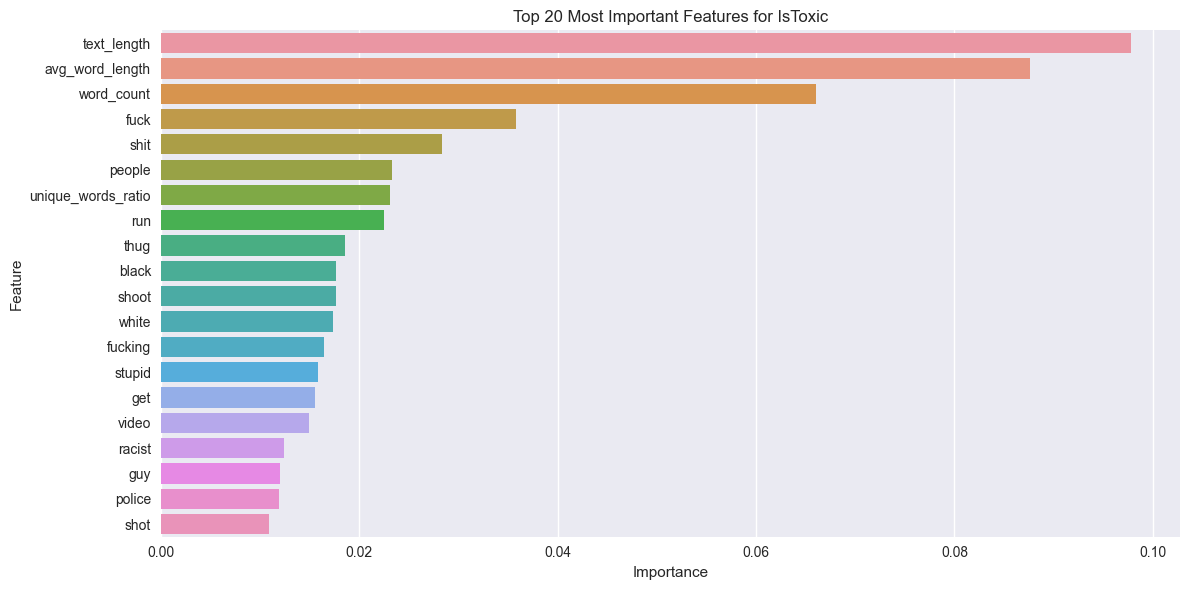


Top 10 most important features for IsToxic:


Feature  Importance
0          text_length    0.097842
4      avg_word_length    0.087628
1           word_count    0.066027
30                fuck    0.035758
79                shit    0.028299
64              people    0.023318
5   unique_words_ratio    0.023073
74                 run    0.022477
94                thug    0.018530
10               black    0.017686


Analyzing IsAbusive...


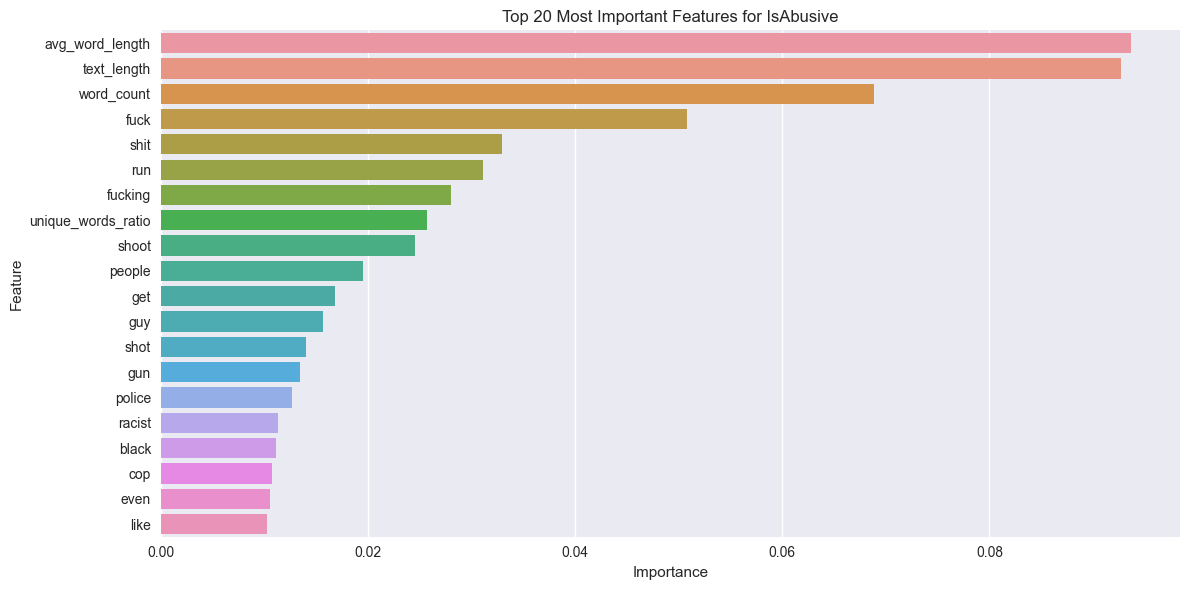


Top 10 most important features for IsAbusive:


Feature  Importance
4      avg_word_length    0.093713
0          text_length    0.092655
1           word_count    0.068839
30                fuck    0.050793
79                shit    0.032970
74                 run    0.031153
31             fucking    0.028009
5   unique_words_ratio    0.025749
80               shoot    0.024576
64              people    0.019488


Analyzing IsThreat...


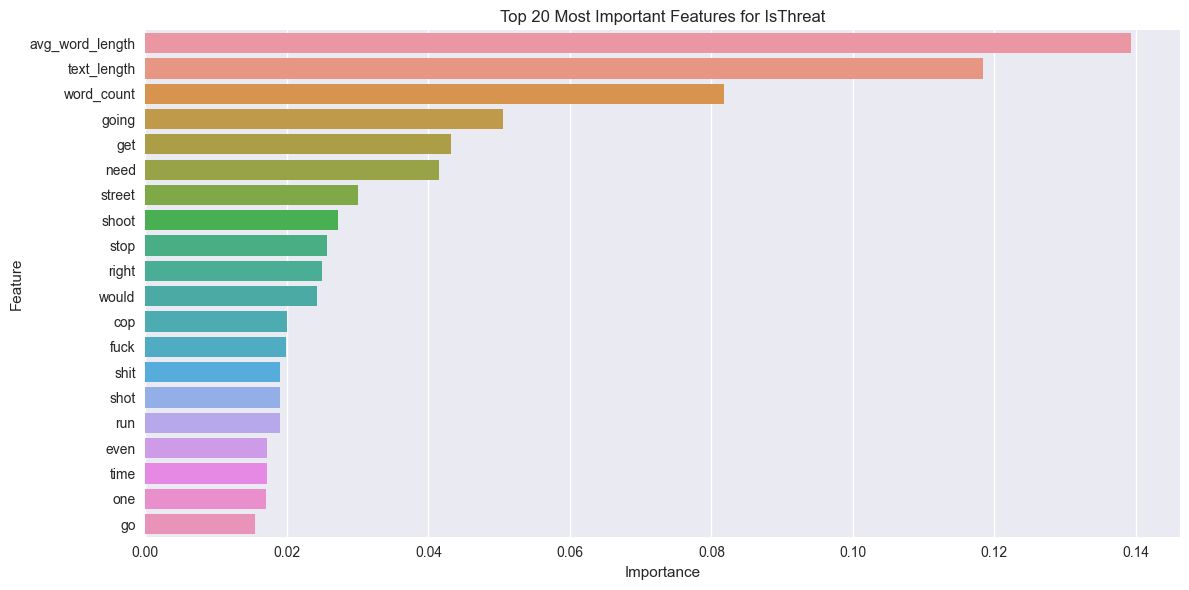


Top 10 most important features for IsThreat:


Feature  Importance
4   avg_word_length    0.139272
0       text_length    0.118383
1        word_count    0.081778
34            going    0.050528
32              get    0.043254
59             need    0.041446
87           street    0.029983
80            shoot    0.027153
85             stop    0.025680
72            right    0.024935


Analyzing IsProvocative...


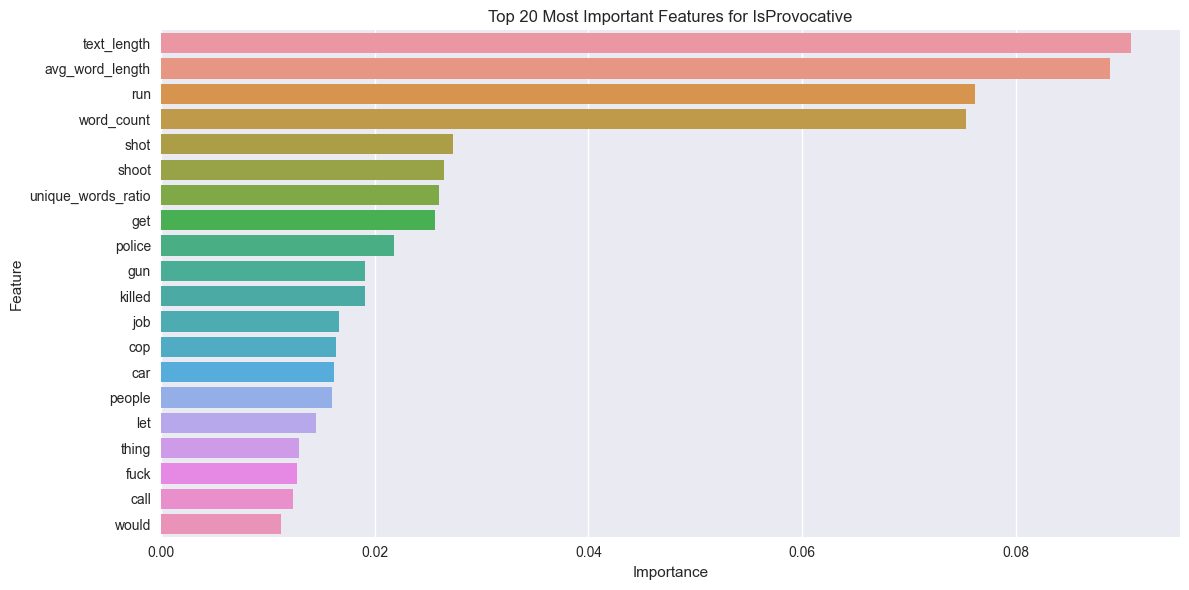


Top 10 most important features for IsProvocative:


Feature  Importance
0          text_length    0.090785
4      avg_word_length    0.088765
74                 run    0.076144
1           word_count    0.075300
81                shot    0.027296
80               shoot    0.026453
5   unique_words_ratio    0.026056
32                 get    0.025662
66              police    0.021769
37                 gun    0.019145


Analyzing IsObscene...


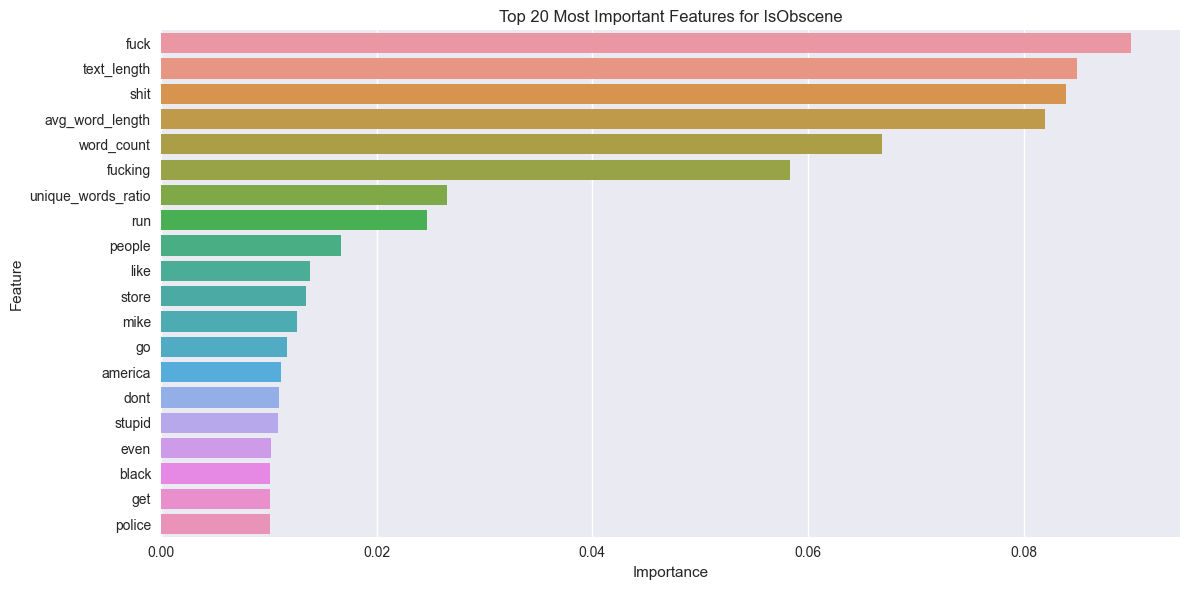


Top 10 most important features for IsObscene:


Feature  Importance
30                fuck    0.089981
0          text_length    0.084948
79                shit    0.083883
4      avg_word_length    0.081925
1           word_count    0.066889
31             fucking    0.058328
5   unique_words_ratio    0.026489
74                 run    0.024716
64              people    0.016746
48                like    0.013813


Analyzing IsHatespeech...


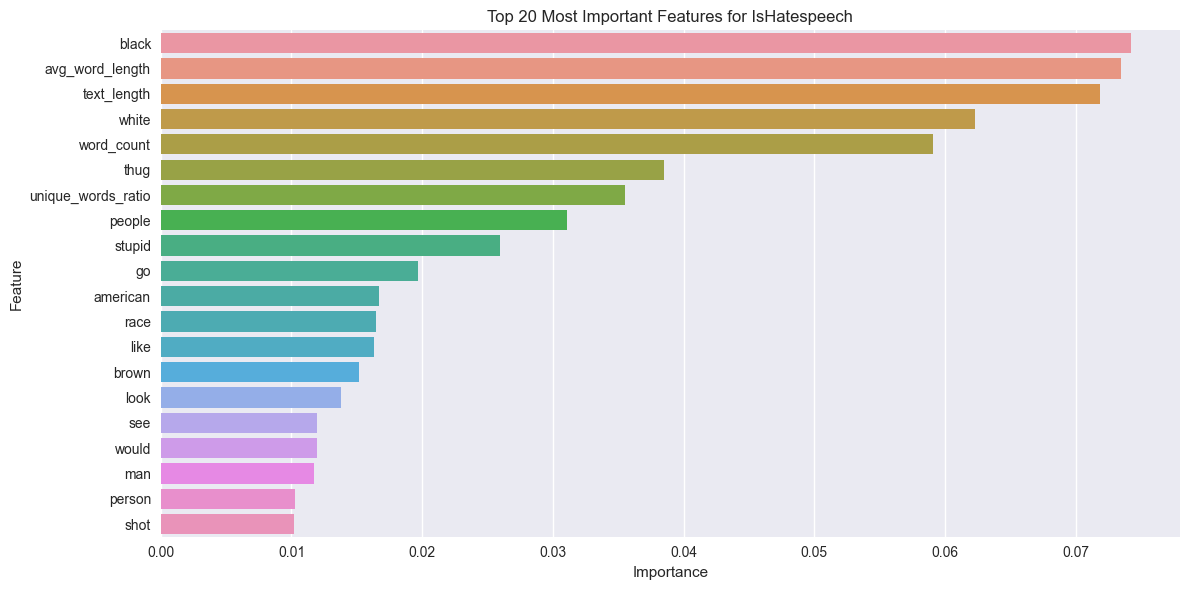


Top 10 most important features for IsHatespeech:


Feature  Importance
10                black    0.074279
4       avg_word_length    0.073455
0           text_length    0.071875
102               white    0.062271
1            word_count    0.059106
94                 thug    0.038491
5    unique_words_ratio    0.035539
64               people    0.031084
88               stupid    0.025947
33                   go    0.019711


Analyzing IsRacist...


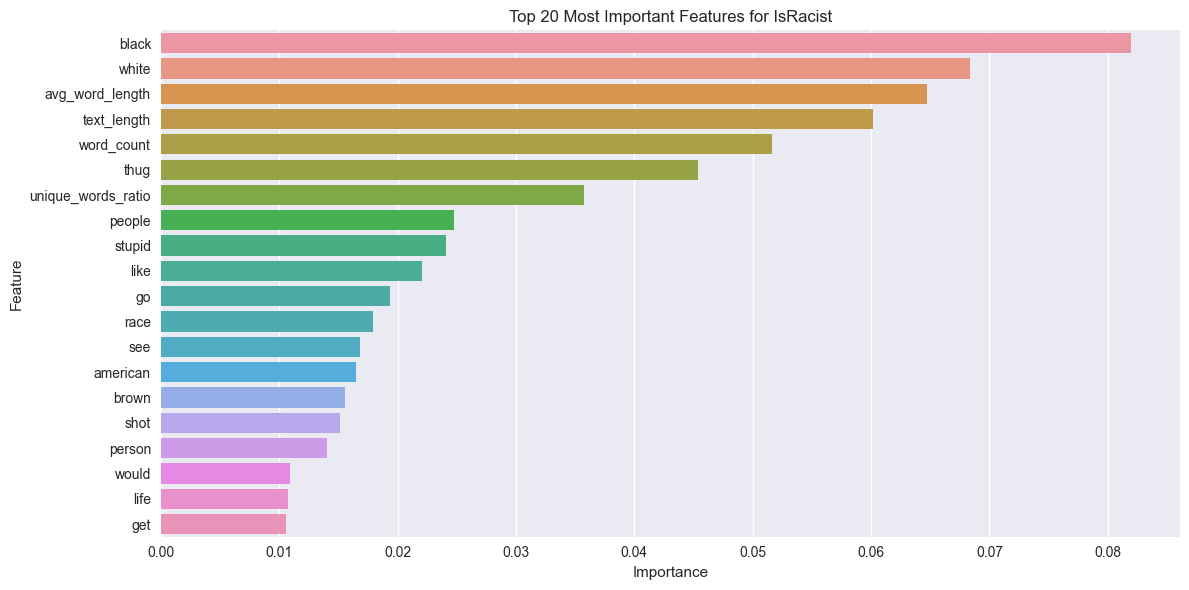


Top 10 most important features for IsRacist:


Feature  Importance
10                black    0.082003
102               white    0.068380
4       avg_word_length    0.064755
0           text_length    0.060152
1            word_count    0.051597
94                 thug    0.045350
5    unique_words_ratio    0.035779
64               people    0.024743
88               stupid    0.024085
48                 like    0.022094

In [18]:
# Part 10: Feature Importance Analysis

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import shap

def analyze_feature_importance(df, toxic_categories):
    """Analyze feature importance for each category"""
    print("=== Feature Importance Analysis ===")
    
    # Prepare features
    text_features = ['text_length', 'word_count', 'caps_ratio', 
                    'punct_ratio', 'avg_word_length', 'unique_words_ratio']
    
    # Scale numeric features
    scaler = StandardScaler()
    X_numeric = scaler.fit_transform(df[text_features])
    X_numeric = pd.DataFrame(X_numeric, columns=text_features)
    
    # Initialize TF-IDF
    tfidf = TfidfVectorizer(max_features=100)
    X_text = tfidf.fit_transform(df['processed_text'])
    
    # Combine features
    X = np.hstack([X_numeric, X_text.toarray()])
    feature_names = text_features + list(tfidf.get_feature_names_out())
    
    importance_results = {}
    
    # Analyze each category
    for category in toxic_categories:
        print(f"\nAnalyzing {category}...")
        
        # Train a Random Forest
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X, df[category])
        
        # Get feature importance
        importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': rf.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        # Plot top 20 features
        plt.figure(figsize=(12, 6))
        sns.barplot(data=importance.head(20), x='Importance', y='Feature')
        plt.title(f'Top 20 Most Important Features for {category}')
        plt.tight_layout()
        plt.show()
        
        importance_results[category] = importance
        
        # Print top features
        print(f"\nTop 10 most important features for {category}:")
        display(importance.head(10))
    
    return importance_results

feature_importance = analyze_feature_importance(df, TOXIC_CATEGORIES)

=== Advanced N-gram Analysis ===

Analyzing n-grams for IsToxic


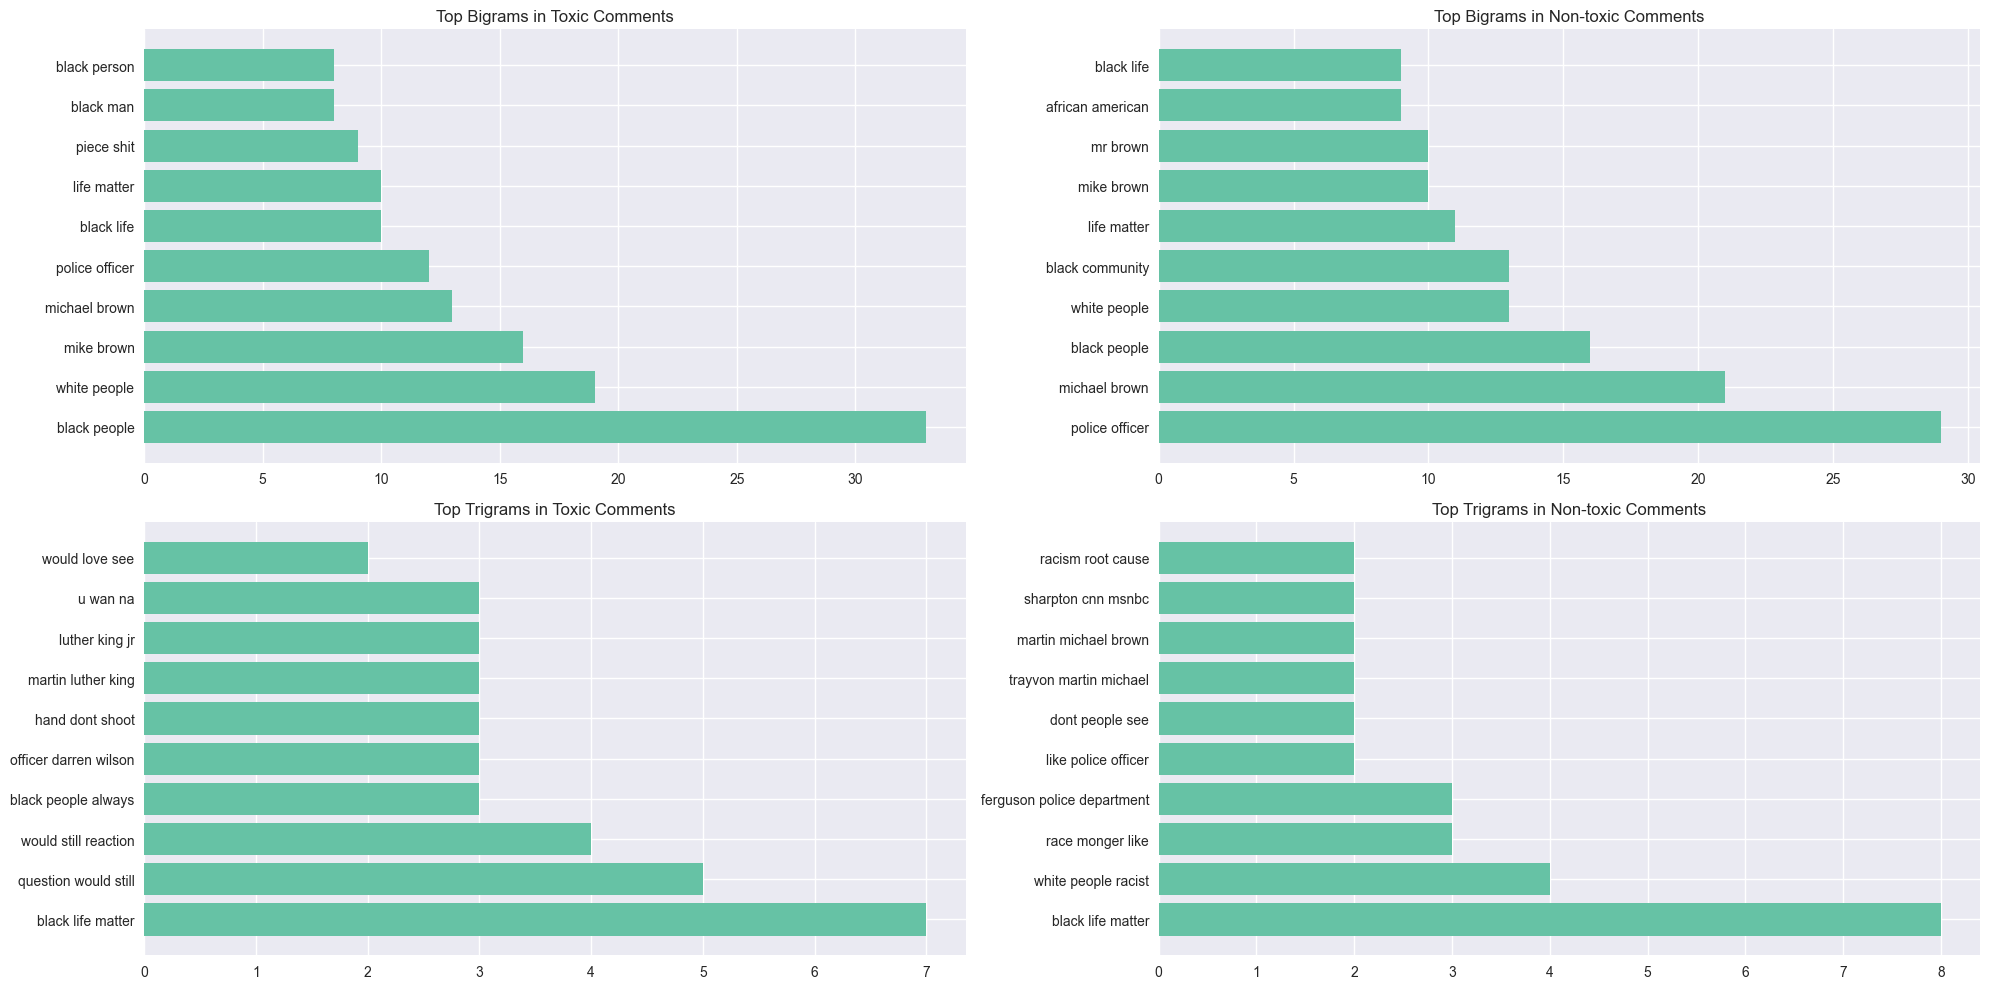

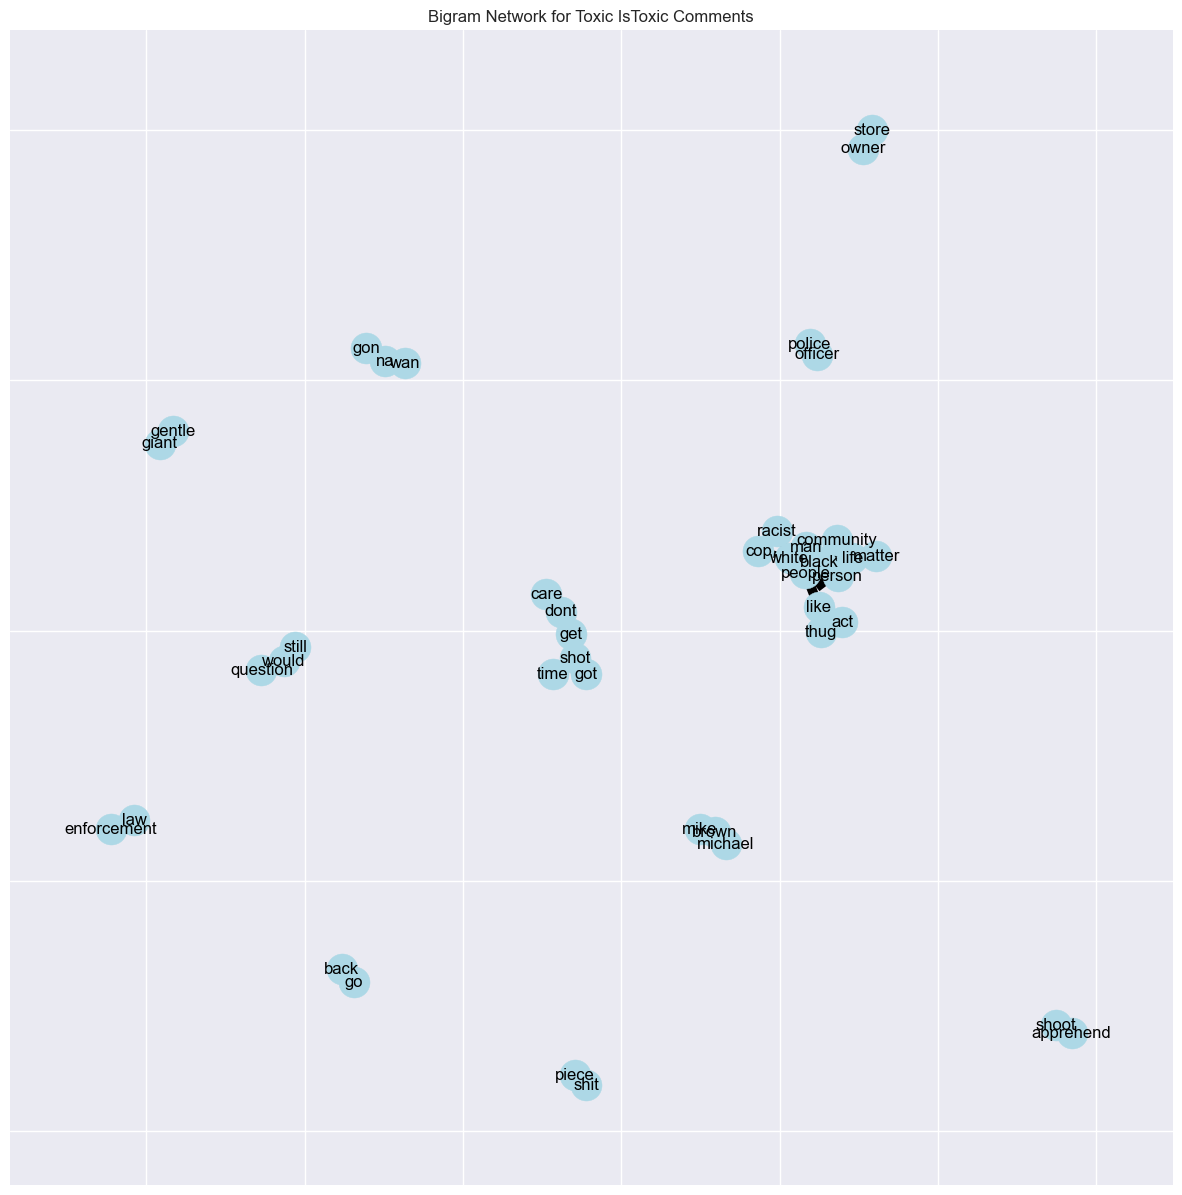


Summary Statistics for IsToxic:
Unique toxic bigrams: 7201
Unique toxic trigrams: 7354
Unique non-toxic bigrams: 7728
Unique non-toxic trigrams: 7841

Analyzing n-grams for IsAbusive


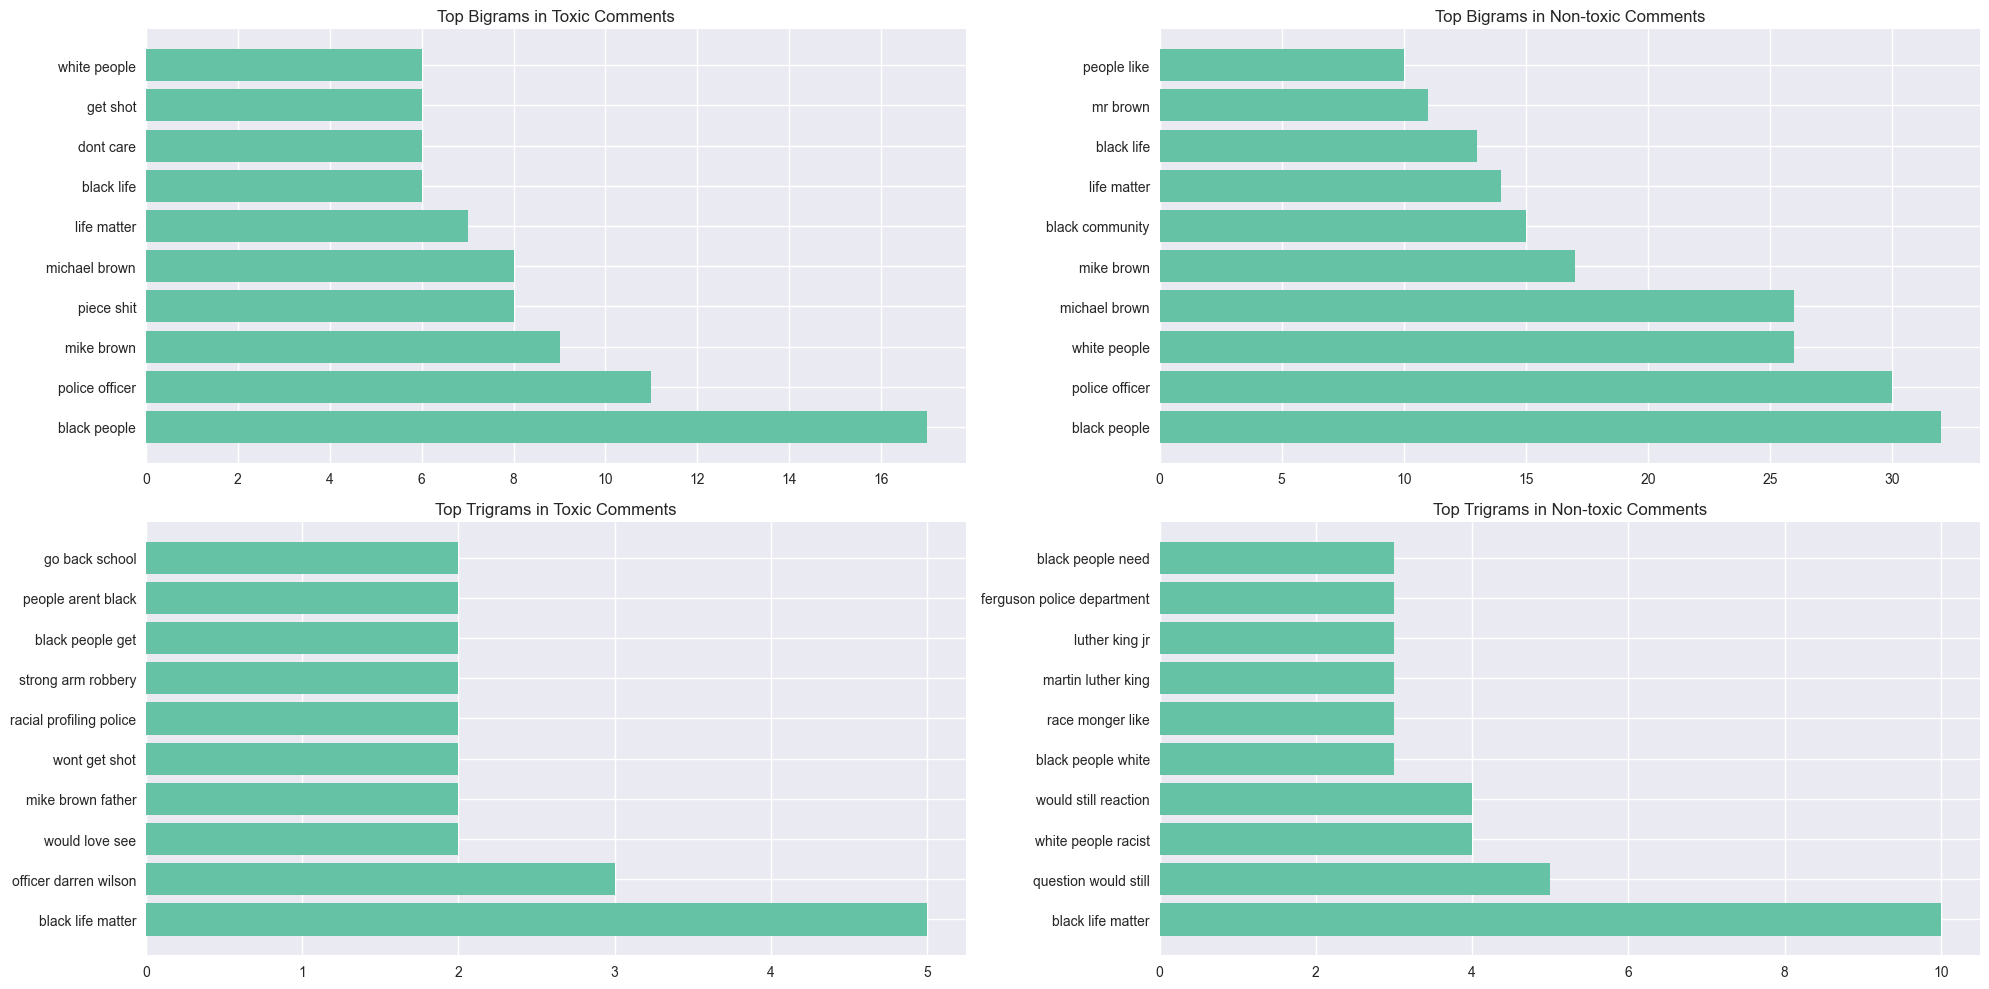

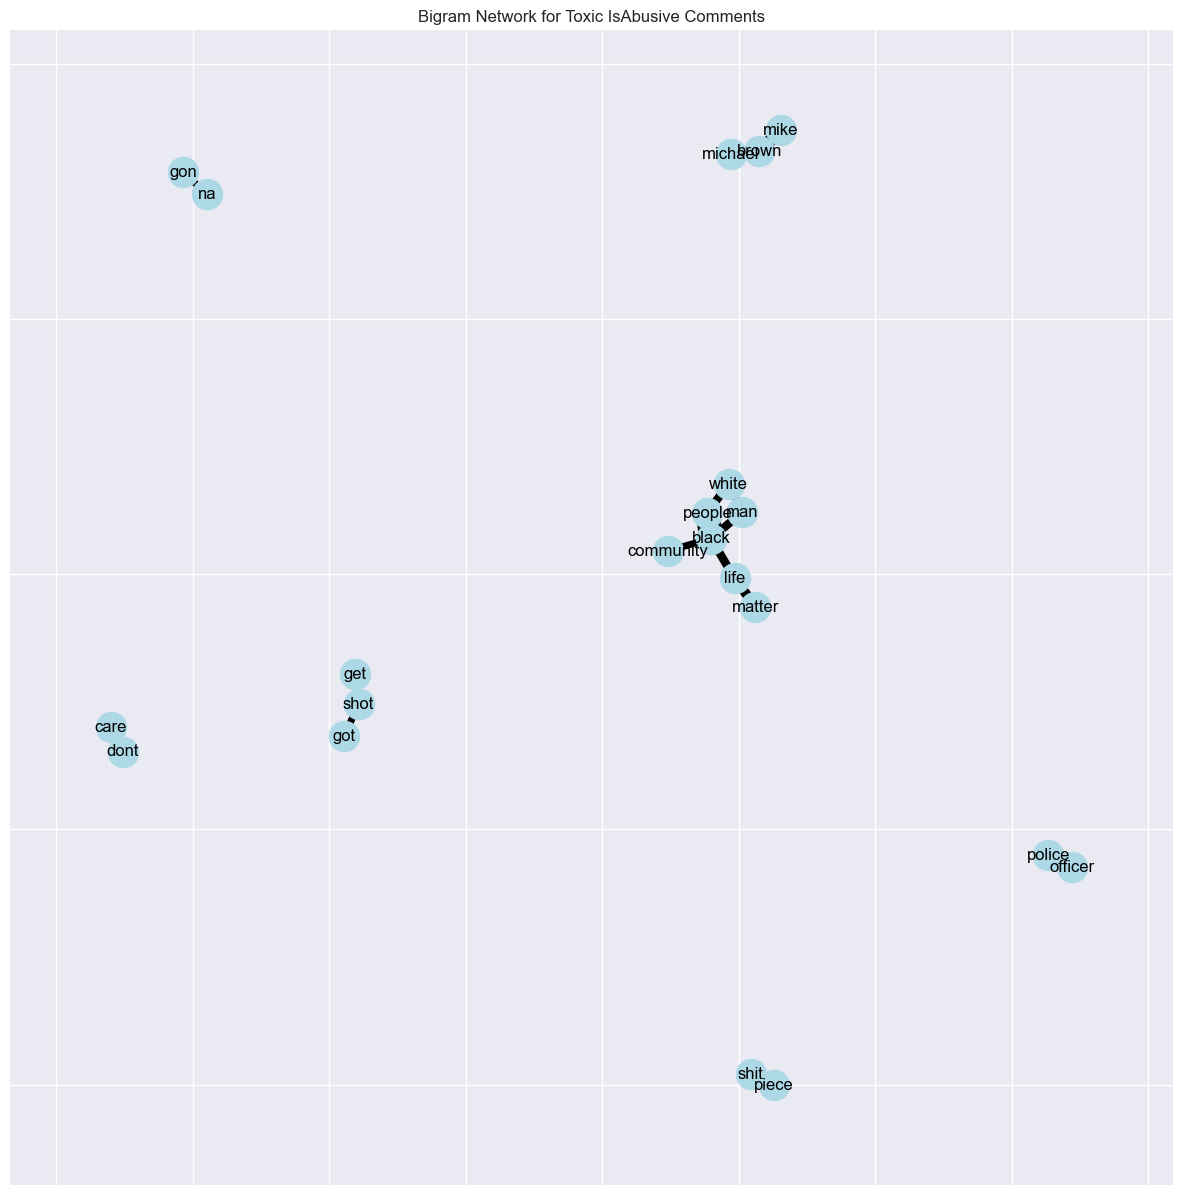


Summary Statistics for IsAbusive:
Unique toxic bigrams: 4929
Unique toxic trigrams: 4914
Unique non-toxic bigrams: 9960
Unique non-toxic trigrams: 10276

Analyzing n-grams for IsThreat


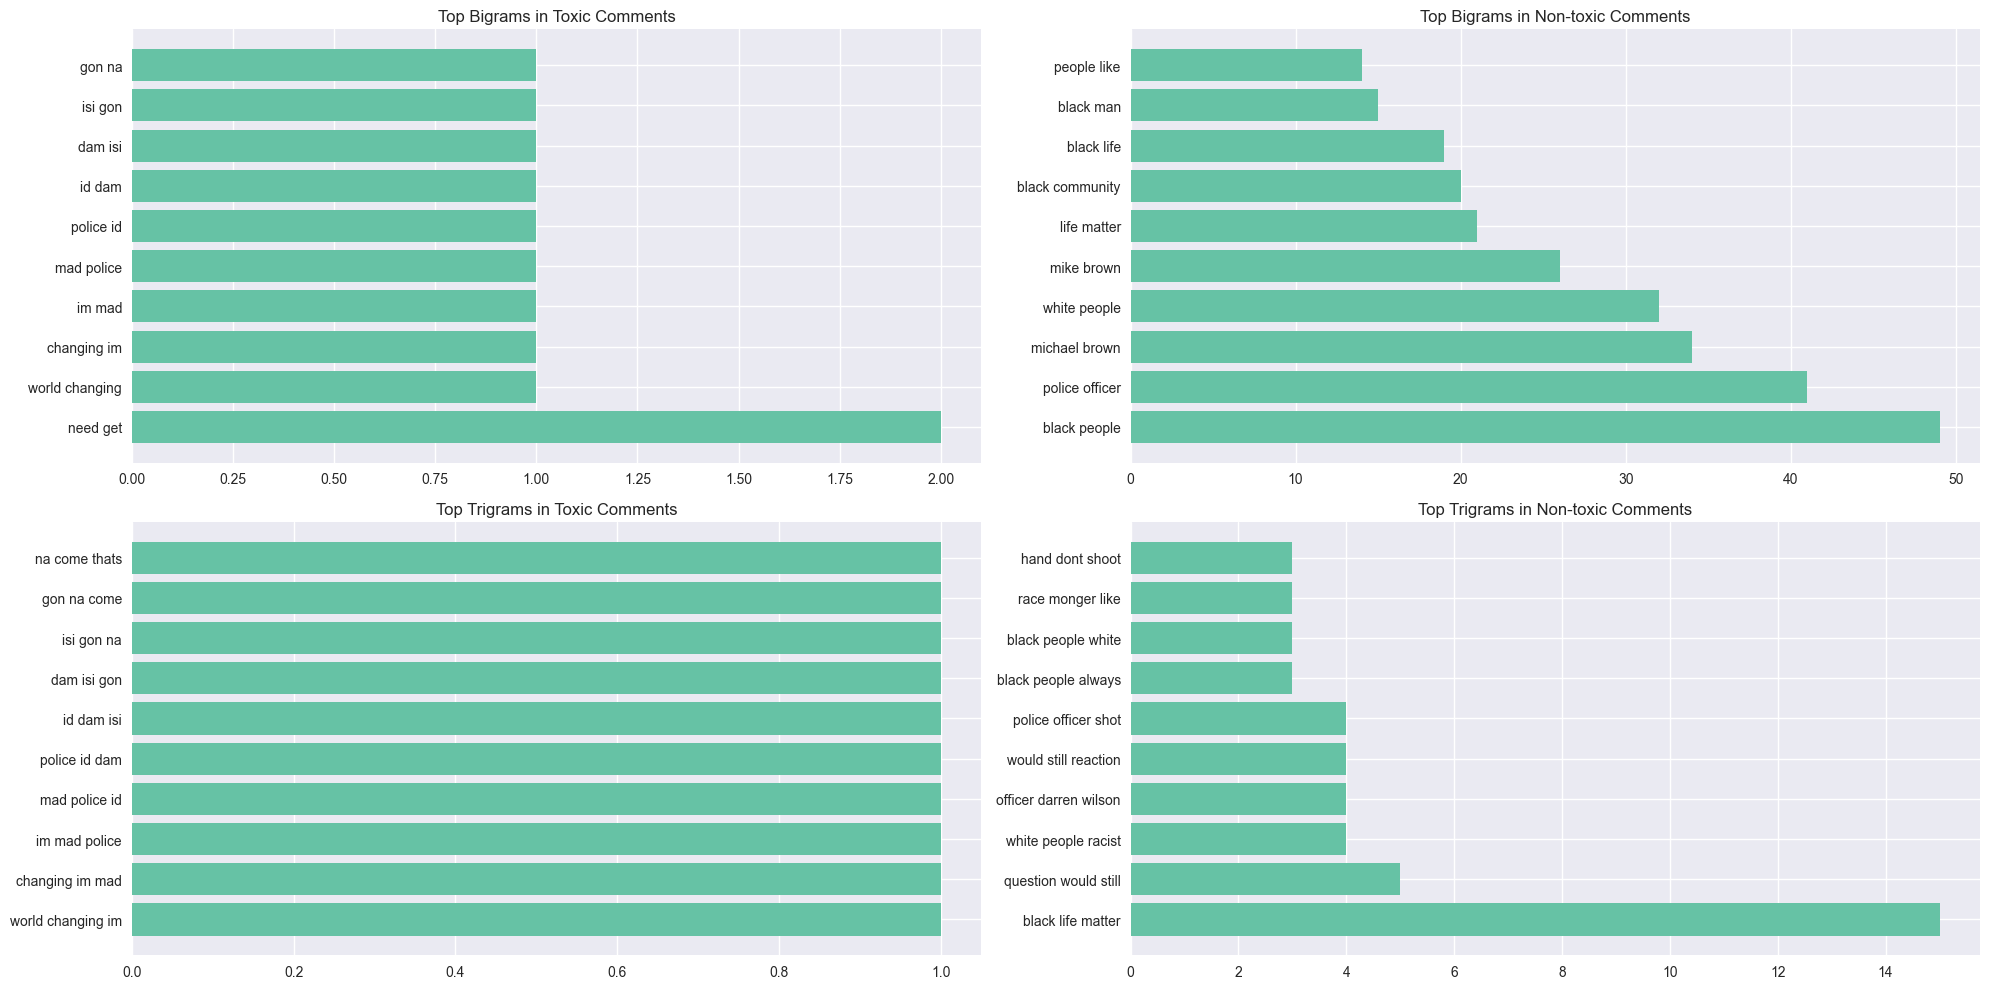

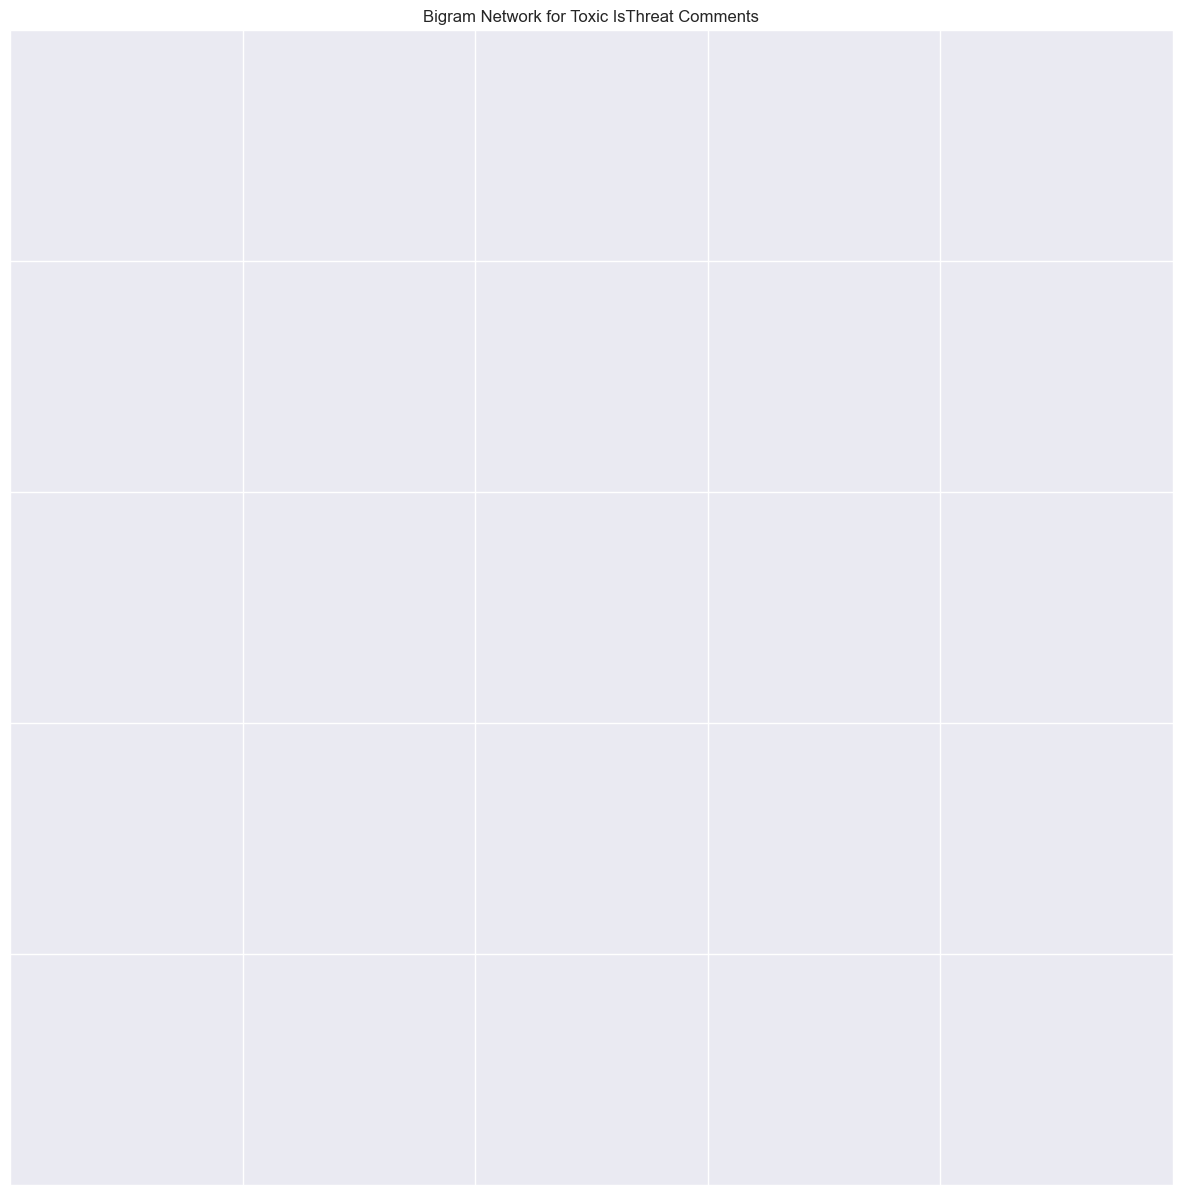


Summary Statistics for IsThreat:
Unique toxic bigrams: 199
Unique toxic trigrams: 180
Unique non-toxic bigrams: 14330
Unique non-toxic trigrams: 14980

Analyzing n-grams for IsProvocative


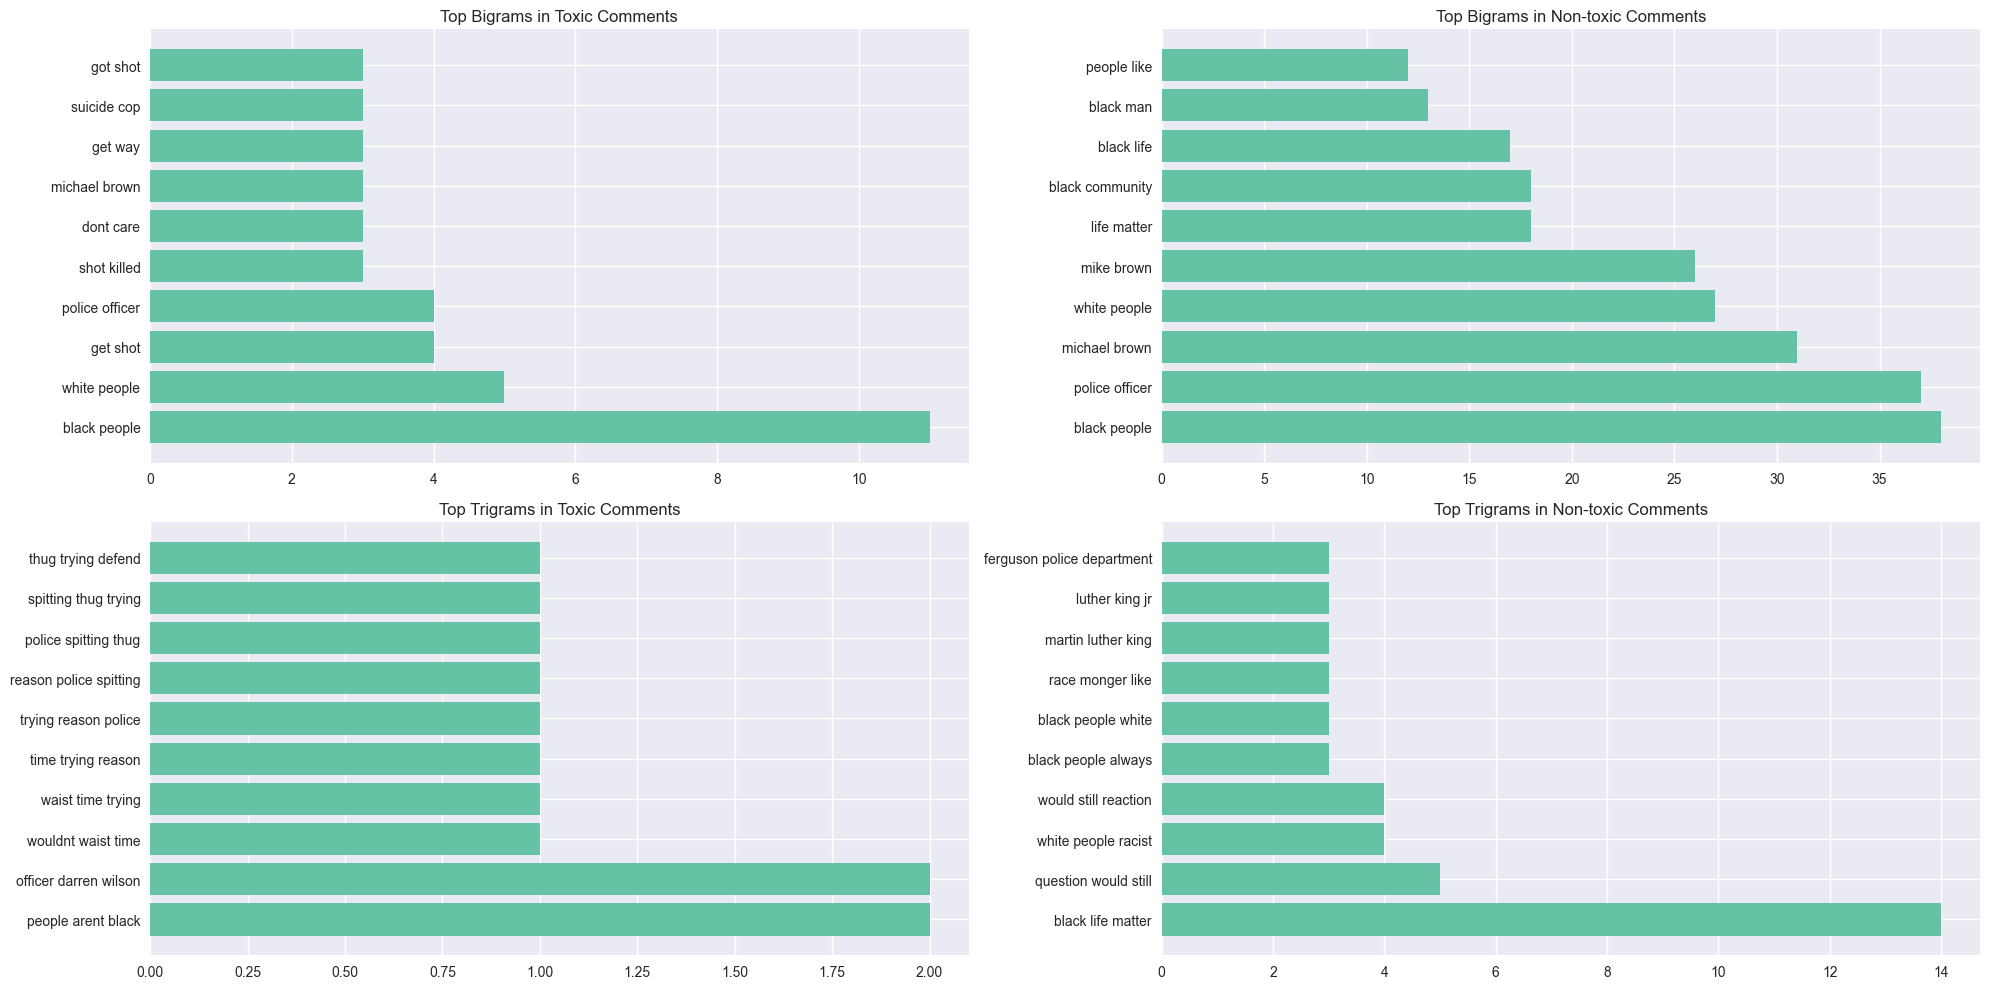

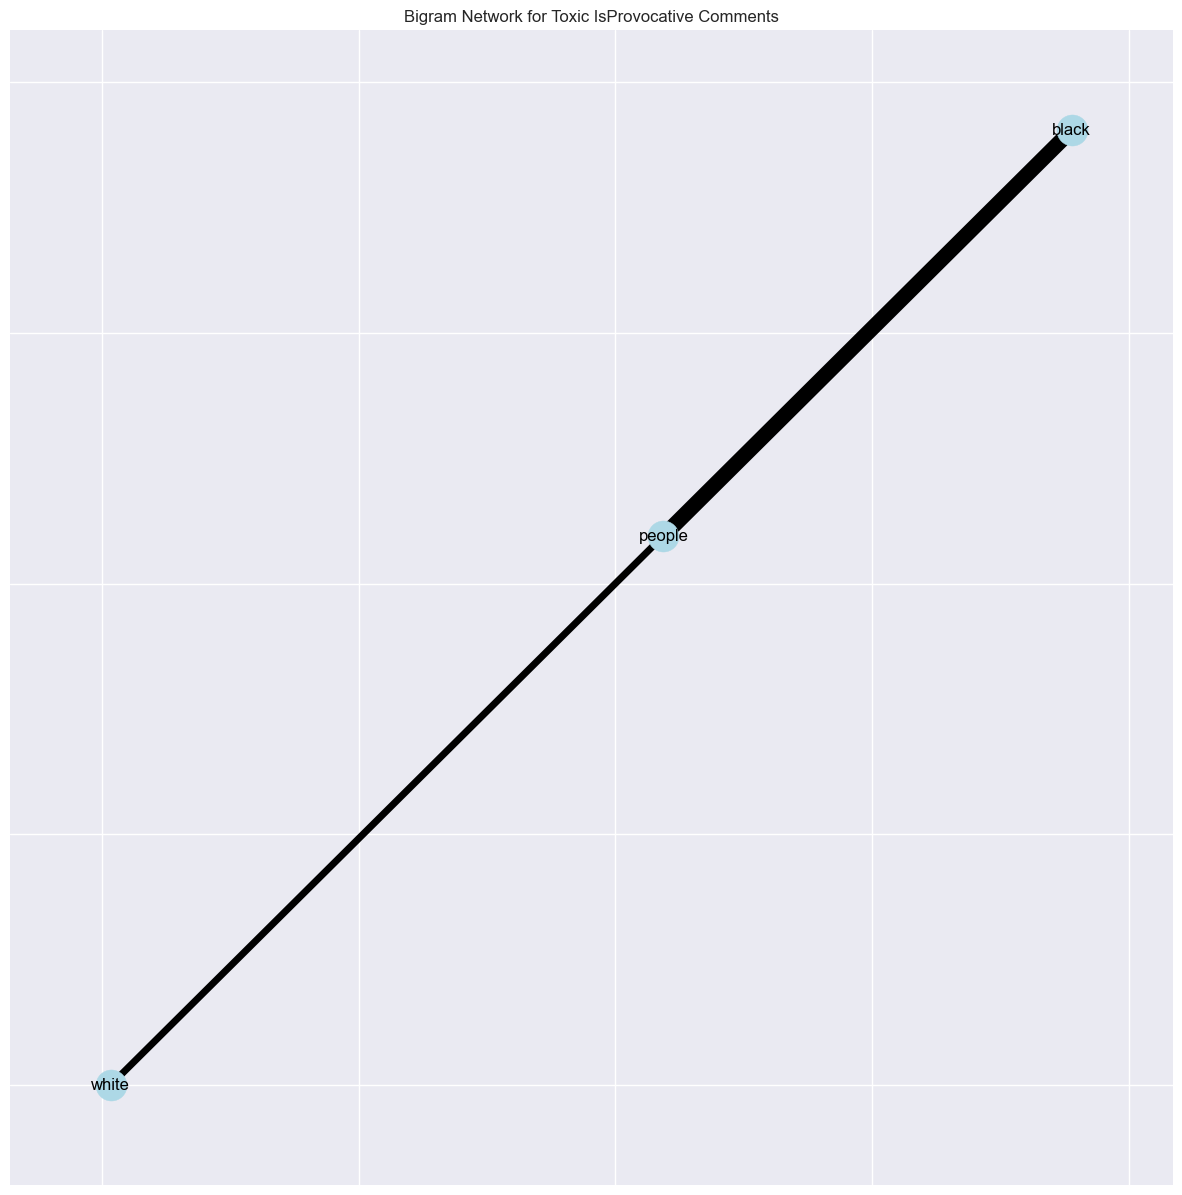


Summary Statistics for IsProvocative:
Unique toxic bigrams: 2463
Unique toxic trigrams: 2413
Unique non-toxic bigrams: 12303
Unique non-toxic trigrams: 12770

Analyzing n-grams for IsObscene


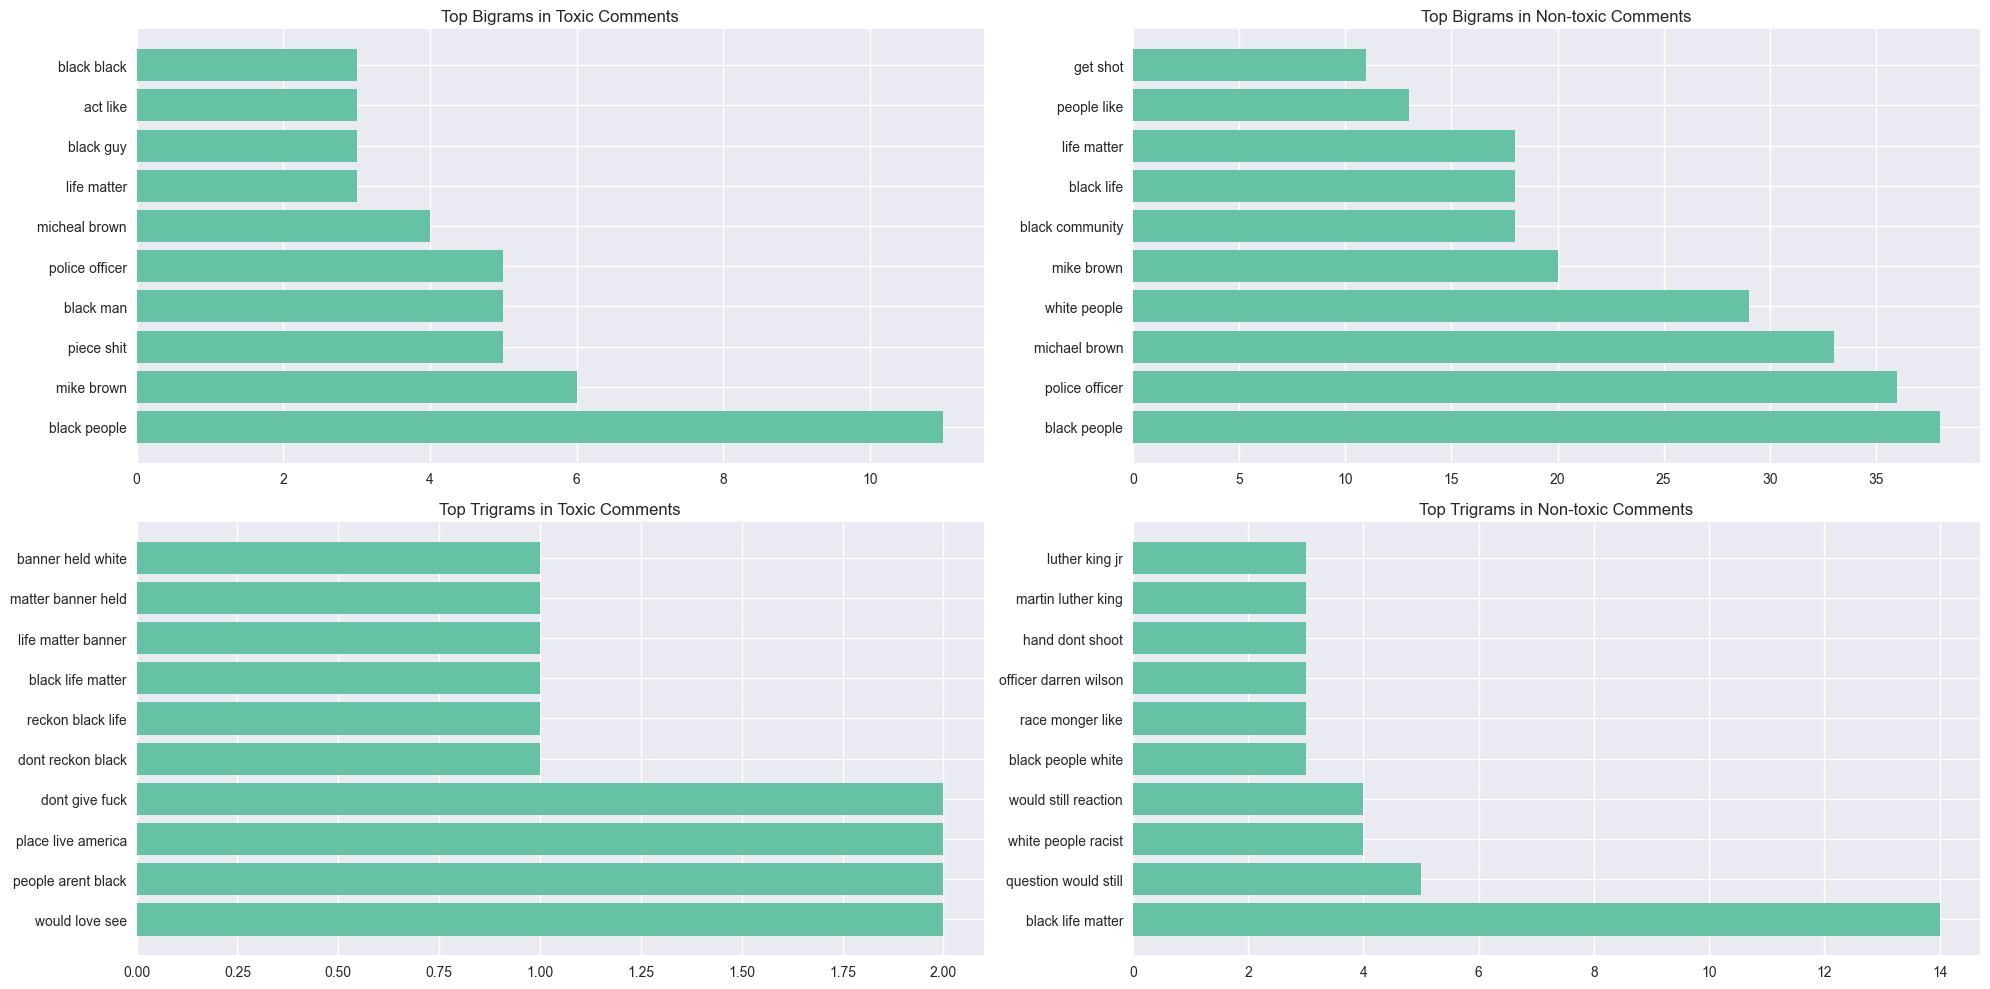

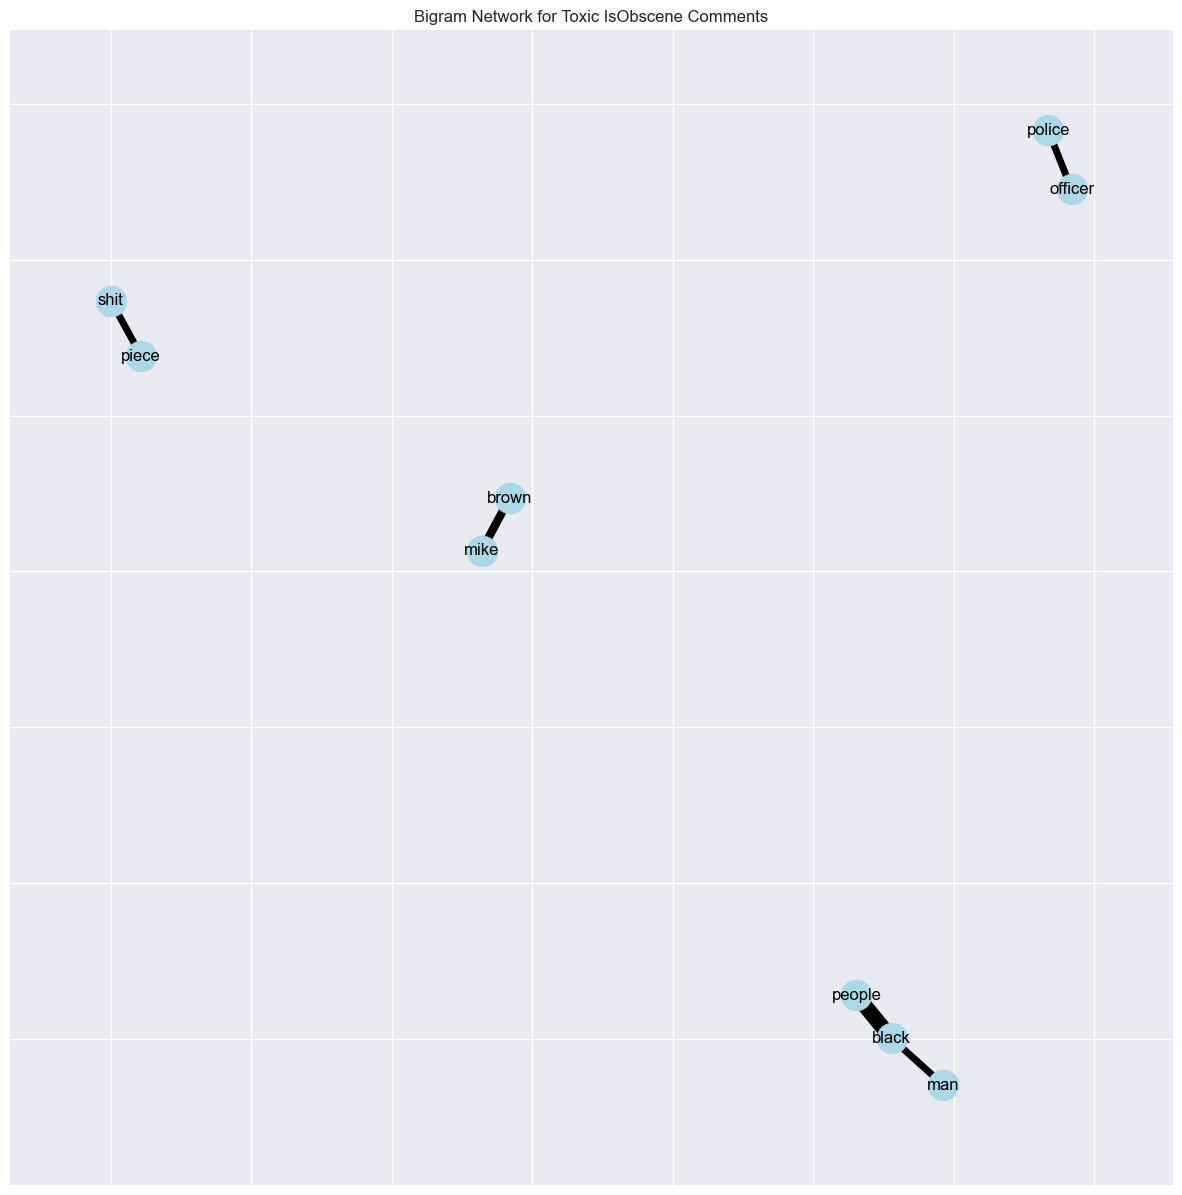


Summary Statistics for IsObscene:
Unique toxic bigrams: 2071
Unique toxic trigrams: 2071
Unique non-toxic bigrams: 12669
Unique non-toxic trigrams: 13111

Analyzing n-grams for IsHatespeech


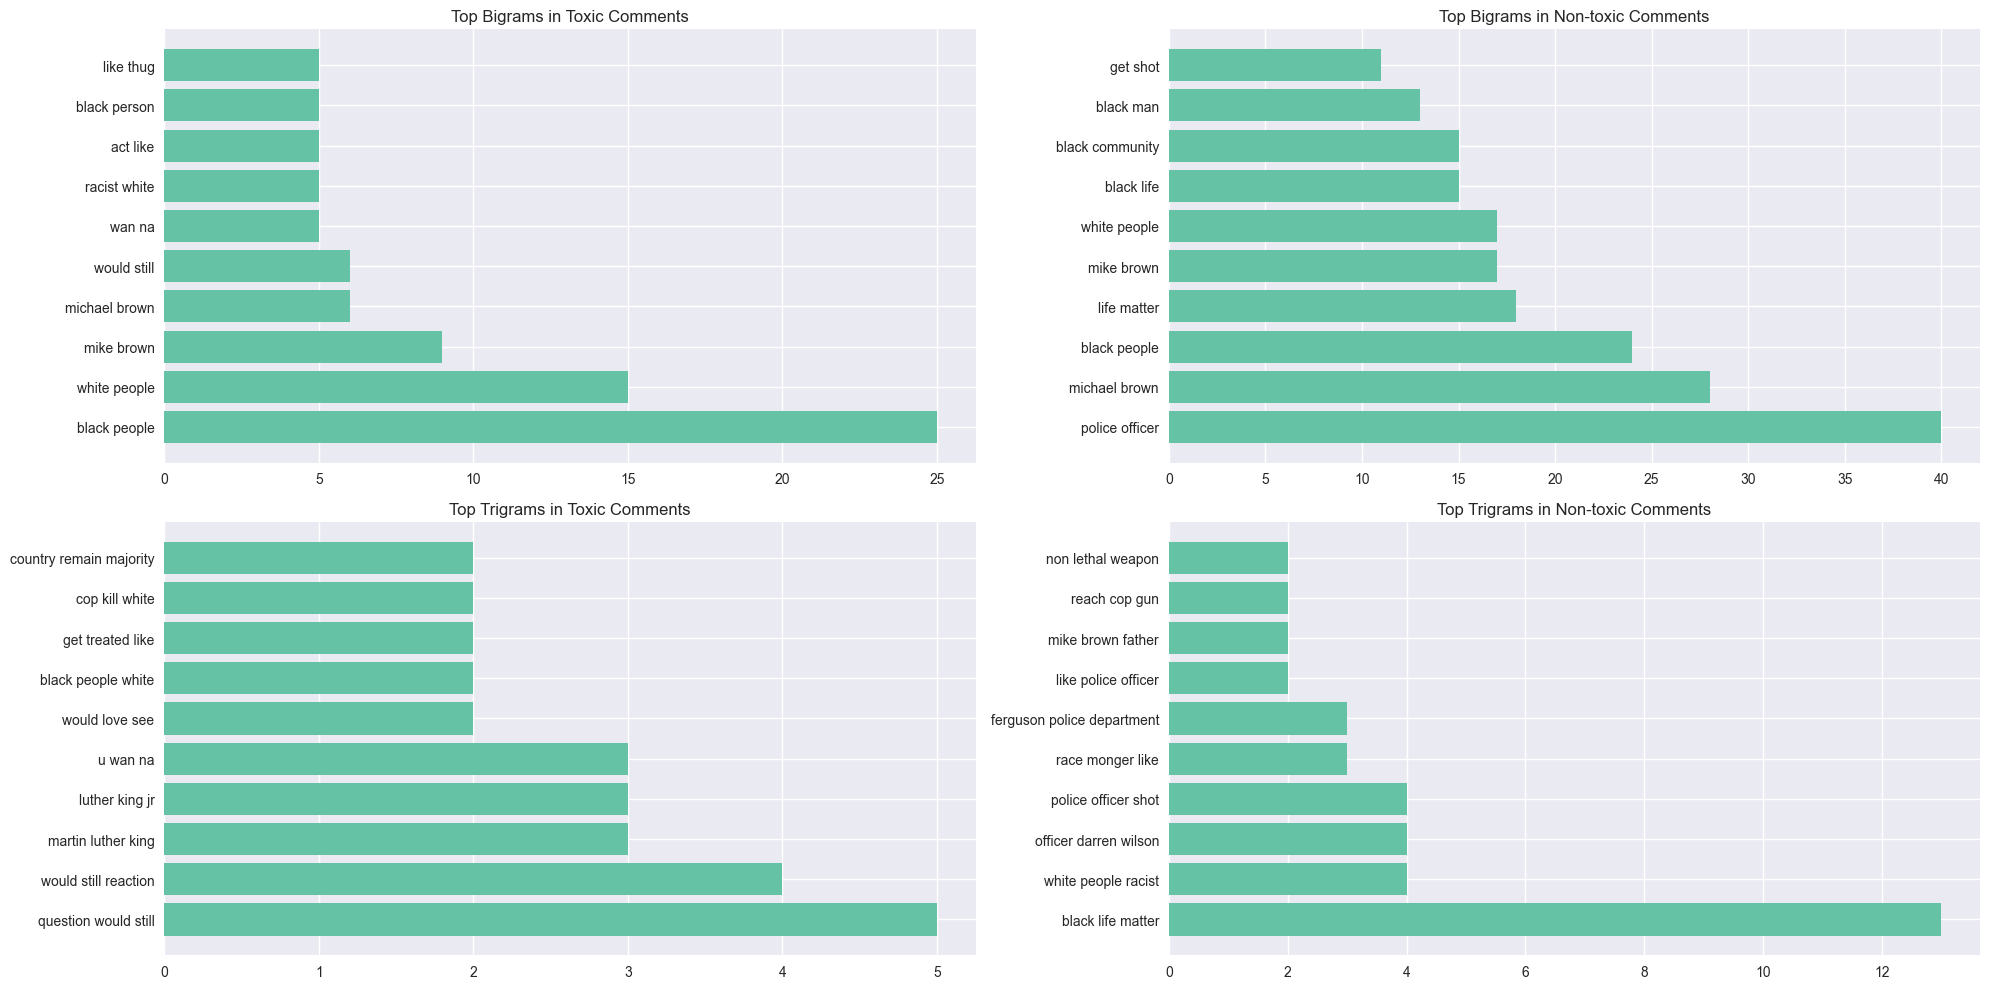

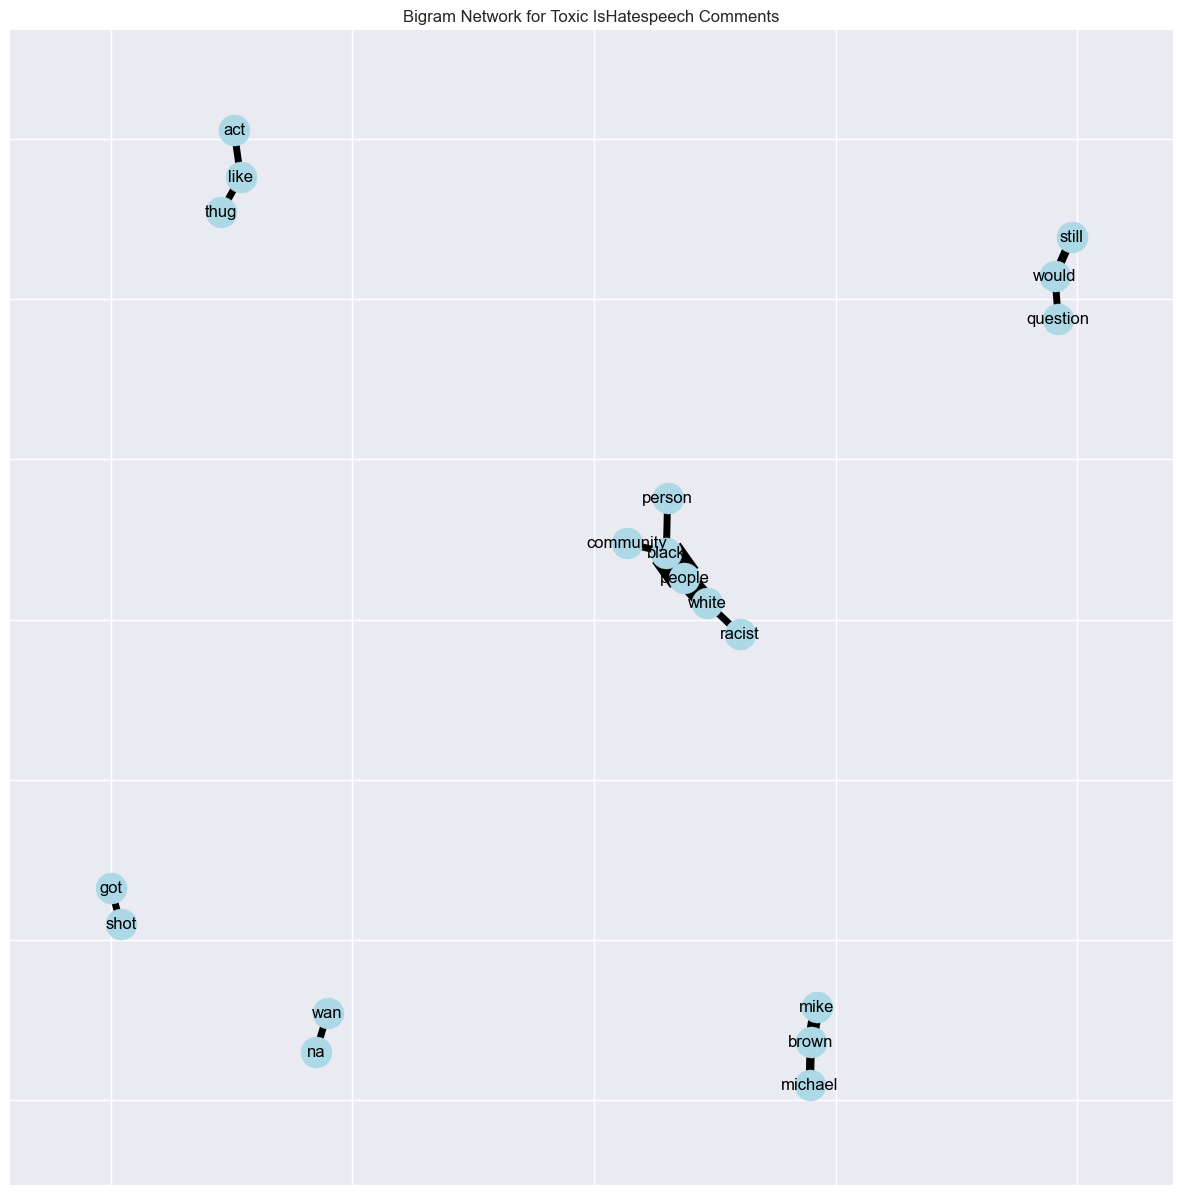


Summary Statistics for IsHatespeech:
Unique toxic bigrams: 3060
Unique toxic trigrams: 3123
Unique non-toxic bigrams: 11739
Unique non-toxic trigrams: 12066

Analyzing n-grams for IsRacist


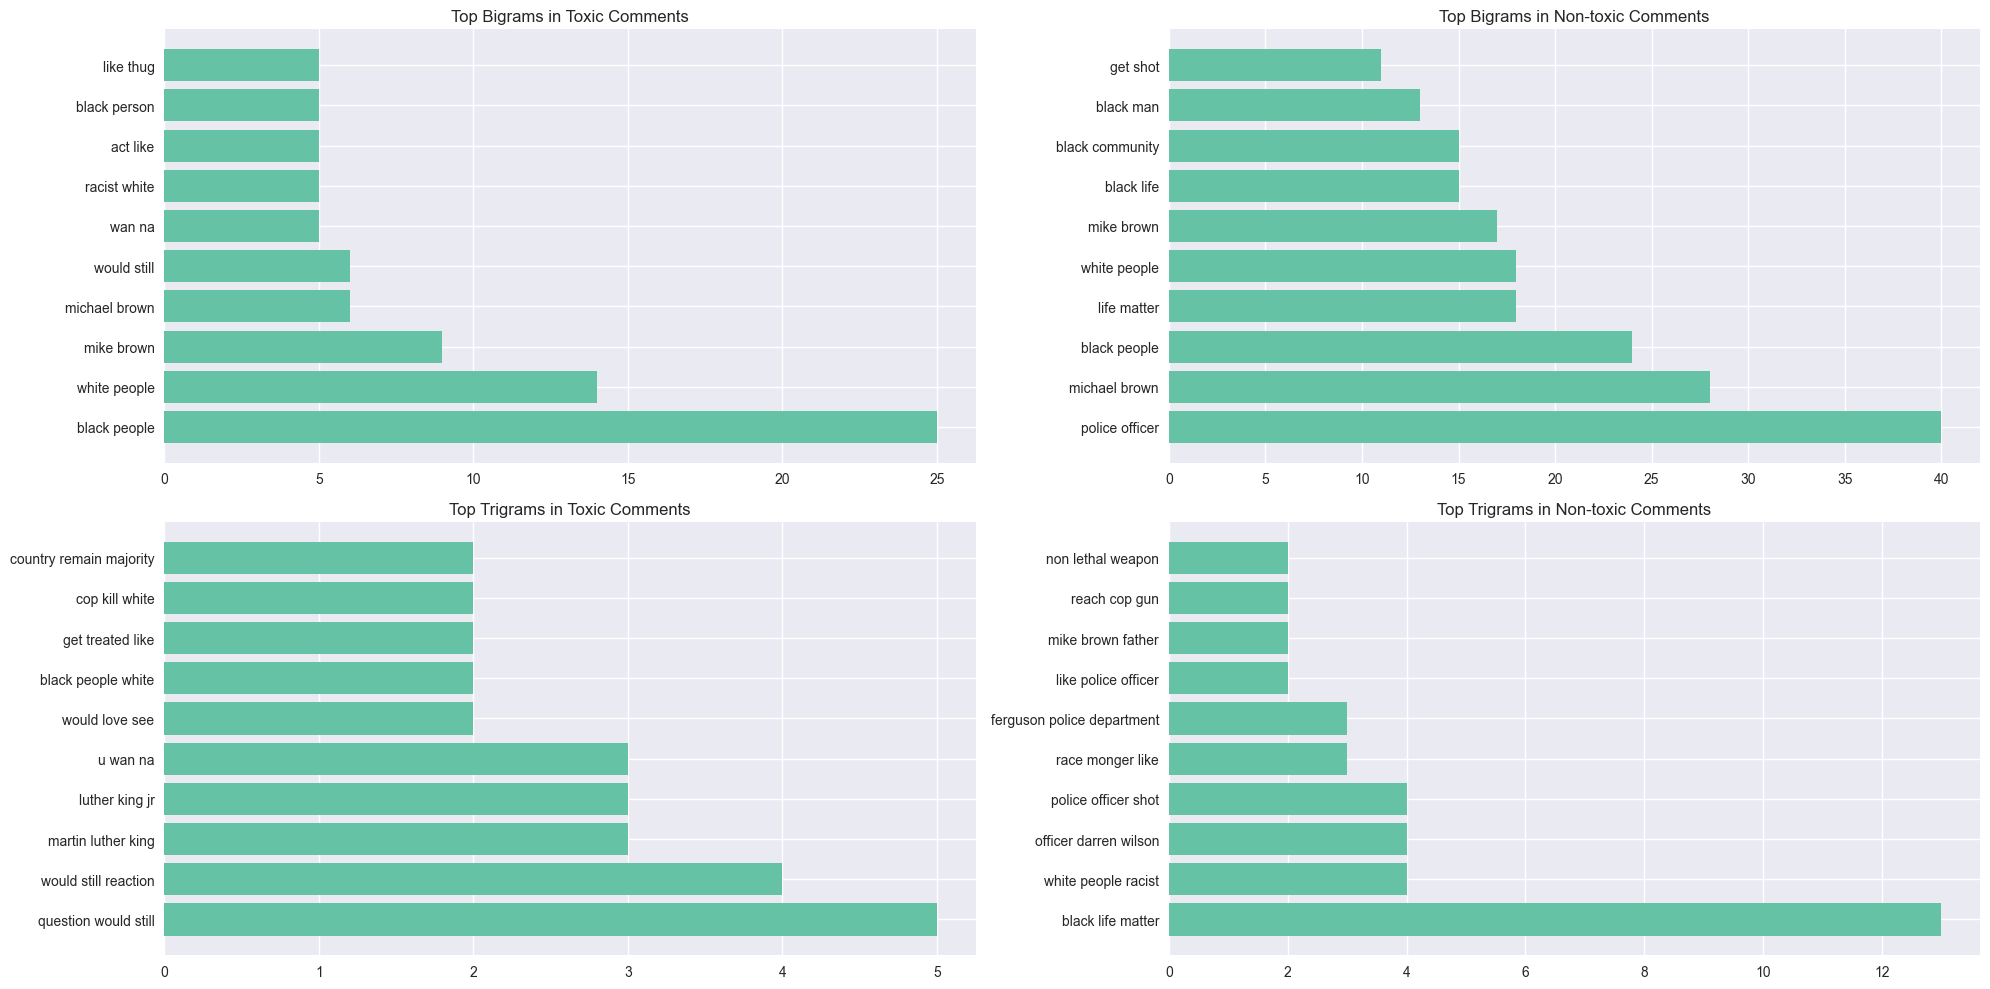

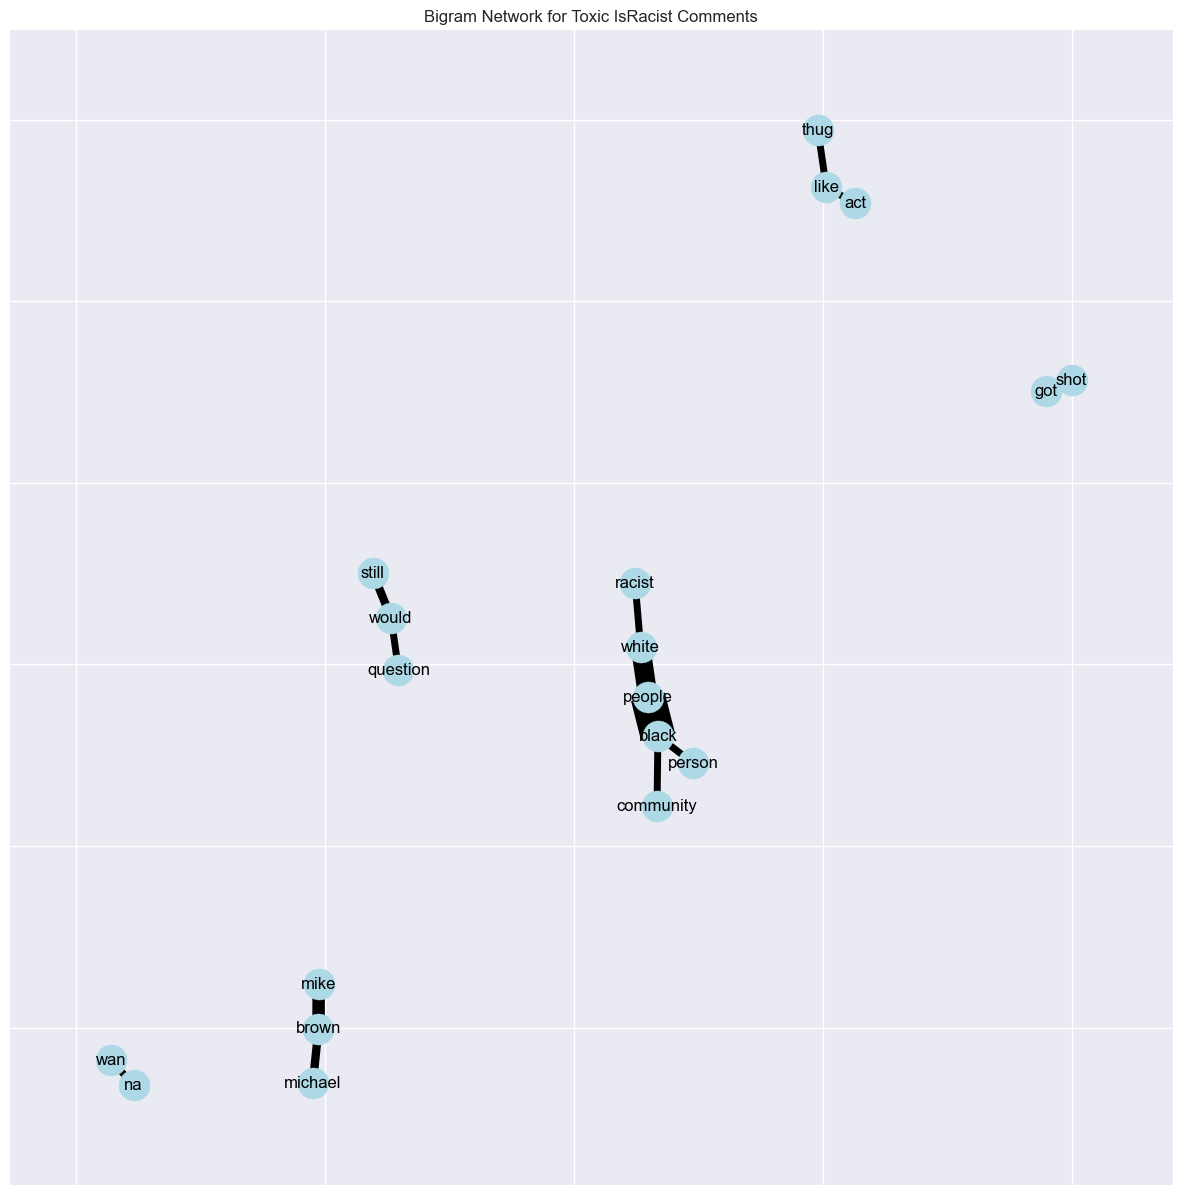


Summary Statistics for IsRacist:
Unique toxic bigrams: 2898
Unique toxic trigrams: 2966
Unique non-toxic bigrams: 11891
Unique non-toxic trigrams: 12222

Analysis results updated successfully with n-gram information!


In [20]:
# Part 11: Advanced N-gram Analysis and Statistics Update

from nltk import ngrams
from nltk.util import everygrams
import networkx as nx

def analyze_ngrams_and_update_stats(df, toxic_categories):
    """Perform comprehensive n-gram analysis and update statistics"""
    print("=== Advanced N-gram Analysis ===")
    
    def extract_ngrams(text, n):
        """Extract n-grams from text with proper preprocessing"""
        if not isinstance(text, str):
            return []
        
        # Tokenize and clean
        tokens = word_tokenize(text.lower())
        # Remove stopwords and non-alphabetic tokens
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens 
                 if token.isalpha() and token not in stop_words]
        
        return list(ngrams(tokens, n))
    
    ngrams_summary = {}
    
    # Analyze by toxicity category
    for category in toxic_categories:
        print(f"\nAnalyzing n-grams for {category}")
        
        # Split texts by category
        toxic_texts = df[df[category]]['processed_text']
        non_toxic_texts = df[~df[category]]['processed_text']
        
        # Get bigrams and trigrams
        toxic_bigrams = [gram for text in toxic_texts 
                        for gram in extract_ngrams(text, 2)]
        toxic_trigrams = [gram for text in toxic_texts 
                         for gram in extract_ngrams(text, 3)]
        
        non_toxic_bigrams = [gram for text in non_toxic_texts 
                            for gram in extract_ngrams(text, 2)]
        non_toxic_trigrams = [gram for text in non_toxic_texts 
                             for gram in extract_ngrams(text, 3)]
        
        # Count frequencies
        toxic_bi_freq = Counter(toxic_bigrams)
        toxic_tri_freq = Counter(toxic_trigrams)
        non_toxic_bi_freq = Counter(non_toxic_bigrams)
        non_toxic_tri_freq = Counter(non_toxic_trigrams)
        
        # Create visualizations
        plt.figure(figsize=(20, 10))
        
        # Plot toxic bigrams
        plt.subplot(2, 2, 1)
        plot_top_ngrams(toxic_bi_freq, 'Top Bigrams in Toxic Comments', n=10)
        
        # Plot non-toxic bigrams
        plt.subplot(2, 2, 2)
        plot_top_ngrams(non_toxic_bi_freq, 'Top Bigrams in Non-toxic Comments', n=10)
        
        # Plot toxic trigrams
        plt.subplot(2, 2, 3)
        plot_top_ngrams(toxic_tri_freq, 'Top Trigrams in Toxic Comments', n=10)
        
        # Plot non-toxic trigrams
        plt.subplot(2, 2, 4)
        plot_top_ngrams(non_toxic_tri_freq, 'Top Trigrams in Non-toxic Comments', n=10)
        
        plt.tight_layout()
        plt.show()
        
        # Create bigram network graph
        plt.figure(figsize=(15, 15))
        create_bigram_network(toxic_bi_freq, f'Bigram Network for Toxic {category} Comments')
        plt.show()
        
        # Store summary statistics
        ngrams_summary[category] = {
            'toxic': {
                'bigrams': dict(toxic_bi_freq.most_common(20)),
                'trigrams': dict(toxic_tri_freq.most_common(20)),
                'unique_bigrams': len(toxic_bi_freq),
                'unique_trigrams': len(toxic_tri_freq)
            },
            'non_toxic': {
                'bigrams': dict(non_toxic_bi_freq.most_common(20)),
                'trigrams': dict(non_toxic_tri_freq.most_common(20)),
                'unique_bigrams': len(non_toxic_bi_freq),
                'unique_trigrams': len(non_toxic_tri_freq)
            }
        }
        
        # Print summary statistics
        print(f"\nSummary Statistics for {category}:")
        print(f"Unique toxic bigrams: {len(toxic_bi_freq)}")
        print(f"Unique toxic trigrams: {len(toxic_tri_freq)}")
        print(f"Unique non-toxic bigrams: {len(non_toxic_bi_freq)}")
        print(f"Unique non-toxic trigrams: {len(non_toxic_tri_freq)}")
    
    return ngrams_summary

def plot_top_ngrams(freq_dict, title, n=10):
    """Plot top n-grams"""
    top_n = dict(freq_dict.most_common(n))
    
    plt.barh(range(len(top_n)), 
            list(top_n.values()),
            align='center')
    plt.yticks(range(len(top_n)), 
              [' '.join(k) for k in top_n.keys()])
    plt.title(title)

def create_bigram_network(bigram_freq, title, threshold=5):
    """Create network graph of bigram relationships"""
    # Create network
    G = nx.Graph()
    
    # Add edges with weights
    for bigram, freq in bigram_freq.items():
        if freq >= threshold:
            G.add_edge(bigram[0], bigram[1], weight=freq)
    
    # Draw network
    pos = nx.spring_layout(G)
    weights = [G[u][v]['weight'] for u,v in G.edges()]
    
    nx.draw_networkx_edges(G, pos, width=weights)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                          node_size=500)
    nx.draw_networkx_labels(G, pos)
    plt.title(title)

# Update the existing analysis results with n-gram summary
def update_analysis_results(ngrams_summary):
    """Update the saved analysis results with n-gram information"""
    try:
        # Load existing results
        with open(PROCESSED_DATA_DIR / 'analysis_results.pkl', 'rb') as f:
            analysis_results = pickle.load(f)
        
        # Add n-gram summary
        analysis_results['ngrams_summary'] = ngrams_summary
        
        # Add timestamp
        analysis_results['last_updated'] = pd.Timestamp.now()
        
        # Save updated results
        with open(PROCESSED_DATA_DIR / 'analysis_results.pkl', 'wb') as f:
            pickle.dump(analysis_results, f)
        
        print("\nAnalysis results updated successfully with n-gram information!")
        
    except Exception as e:
        print(f"Error updating analysis results: {str(e)}")

# Run the analysis and update stats
ngrams_summary = analyze_ngrams_and_update_stats(df, TOXIC_CATEGORIES)
update_analysis_results(ngrams_summary)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from gensim.models import Word2Vec
import numpy as np
from typing import Dict, List, Tuple, Union
import pandas as pd

class EnhancedTextVectorizer:
    def __init__(self, 
                 max_features: int = 10000,
                 ngram_range: Tuple[int, int] = (1, 3),
                 embedding_dim: int = 300,
                 reduced_dim: int = 100):
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.embedding_dim = embedding_dim
        self.reduced_dim = reduced_dim
        
        # Enhanced TF-IDF with better preprocessing
        self.tfidf = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            sublinear_tf=True,
            strip_accents='unicode',
            analyzer='word',
            token_pattern=r'\w{1,}',
            stop_words='english',
            dtype=np.float32,
            norm='l2',
            smooth_idf=True,
            use_idf=True
        )
        
        # Multiple dimension reduction techniques
        self.svd = TruncatedSVD(n_components=reduced_dim, random_state=42)
        self.pca = PCA(n_components=reduced_dim, random_state=42)
        
        # Initialize additional attributes
        self.word2vec = None
        self.vocabulary = None
        self.feature_importance = None
        self.category_specific_patterns = {}
        
    def preprocess_for_embeddings(self, text: str) -> List[str]:
        """Enhanced preprocessing for embeddings"""
        # Add preprocessing from Part 2
        return text.split()  # Placeholder - should use TextPreprocessor
        
    def fit(self, texts: List[str], toxic_texts: List[str], non_toxic_texts: List[str]) -> None:
        """Enhanced fitting with category-specific patterns"""
        # Fit TF-IDF
        print("Fitting TF-IDF vectorizer...")
        self.tfidf.fit(texts)
        
        # Train Word2Vec with enhanced preprocessing
        print("Training Word2Vec model...")
        tokenized_texts = [self.preprocess_for_embeddings(text) for text in texts]
        self.word2vec = Word2Vec(
            sentences=tokenized_texts,
            vector_size=self.embedding_dim,
            window=5,
            min_count=2,
            workers=4,
            sg=1,
            negative=15,  # Negative sampling for better quality
            epochs=10     # More training epochs
        )
        
        # Create enhanced vocabulary with n-gram information
        self.vocabulary = set(self.word2vec.wv.index_to_key)
        self.vocabulary.update(self.tfidf.get_feature_names_out())
        
        # Learn category-specific patterns
        print("Learning category-specific patterns...")
        self._learn_category_patterns(toxic_texts, non_toxic_texts)
        
        # Fit dimension reduction
        print("Fitting dimension reduction...")
        initial_vectors = self.tfidf.transform(texts)
        self.svd.fit(initial_vectors)
        
    def _learn_category_patterns(self, toxic_texts: List[str], non_toxic_texts: List[str]) -> None:
        """Learn and store category-specific patterns"""
        # Add pattern learning from Part 11
        pass  # Implementation needed
        
    def transform(self, texts: List[str]) -> Dict[str, np.ndarray]:
        """Enhanced transform with multiple representations"""
        vectors = {}
        
        # TF-IDF transformation
        print("Generating TF-IDF vectors...")
        vectors['tfidf'] = self.tfidf.transform(texts)
        vectors['reduced_tfidf'] = self.svd.transform(vectors['tfidf'])
        
        # Generate Word2Vec embeddings with attention
        print("Generating Word2Vec embeddings...")
        doc_vectors = []
        for text in texts:
            tokens = self.preprocess_for_embeddings(text)
            token_vectors = []
            token_weights = []  # For attention mechanism
            
            for token in tokens:
                if token in self.vocabulary:
                    vector = self.word2vec.wv[token]
                    importance = self._get_token_importance(token)
                    token_vectors.append(vector)
                    token_weights.append(importance)
            
            if token_vectors:
                # Weighted average using attention
                weights = np.array(token_weights)
                weights = weights / weights.sum()  # Normalize
                doc_vector = np.average(token_vectors, weights=weights, axis=0)
            else:
                doc_vector = np.zeros(self.embedding_dim)
            
            doc_vectors.append(doc_vector)
        
        vectors['word2vec'] = np.array(doc_vectors)
        
        return vectors
    
    def _get_token_importance(self, token: str) -> float:
        """Calculate token importance based on TF-IDF and category patterns"""
        # Implementation needed - use TF-IDF scores and category patterns
        return 1.0  # Placeholder

def create_combined_features(df: pd.DataFrame, 
                           vectorizer: EnhancedTextVectorizer,
                           toxic_categories: List[str]) -> Tuple[np.ndarray, List[str]]:
    """Create enhanced combined feature matrix"""
    # Get text representations
    vectors = vectorizer.transform(df['processed_text'].tolist())
    
    # Combine with existing features
    manual_features = [
        'caps_ratio', 'punct_ratio', 'avg_word_length', 'unique_words_ratio',
        # Add new features from Part 6
        'sentiment_score', 'readability_score', 'pos_diversity'
    ]
    
    X_manual = df[manual_features].values
    X_combined = np.hstack([
        X_manual,
        vectors['reduced_tfidf'],
        vectors['word2vec']
    ])
    
    # Create feature names with descriptions
    feature_names = (
        manual_features +
        [f'tfidf_{i}' for i in range(vectorizer.reduced_dim)] +
        [f'w2v_{i}' for i in range(vectorizer.embedding_dim)]
    )
    
    return X_combined, feature_names

Loading processed data...
Loaded DataFrame with shape: (1000, 22)
Available categories: ['IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist']

Total texts: 1000
Toxic texts: 462
Non-toxic texts: 538

Fitting TF-IDF vectorizer...
Training Word2Vec model...
Vocabulary size: 11857
Learning category-specific patterns...
Fitting dimension reduction...
Generating TF-IDF vectors...
Generating Word2Vec embeddings...
Generating TF-IDF vectors...
Generating Word2Vec embeddings...


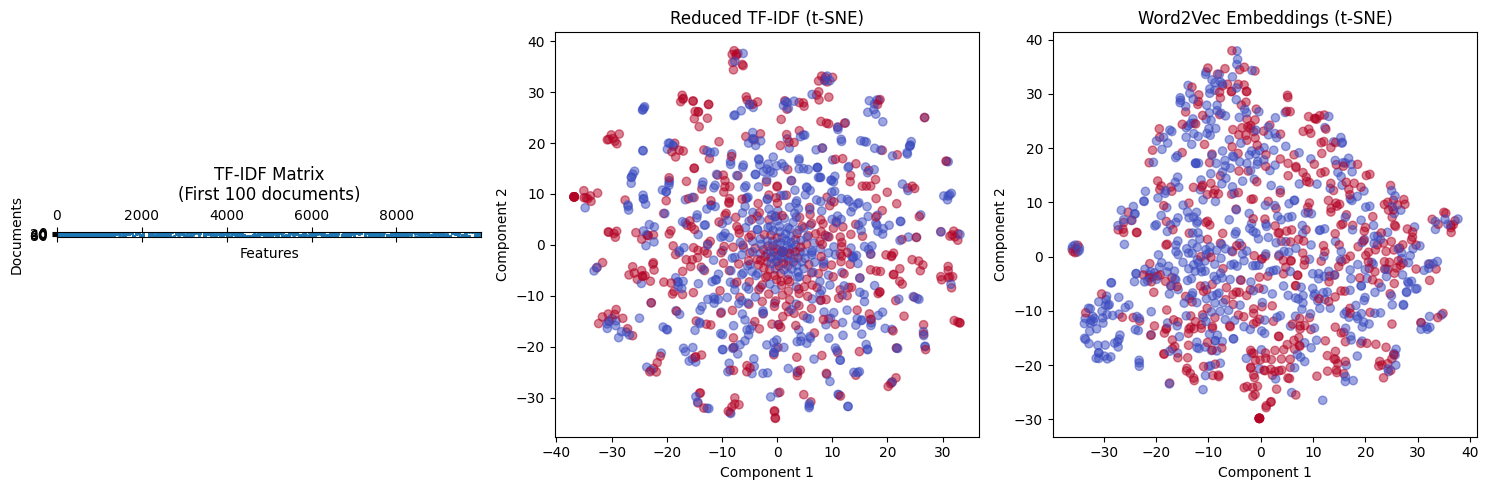


Saving vectorizer and features...
Vectorizer and features saved successfully!


In [20]:
# Part 13: Complete Enhanced Text Vectorization Implementation

# Setup imports
import os
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from gensim.models import Word2Vec
from typing import Dict, List, Tuple, Union
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import pickle

class EnhancedTextVectorizer:
    def __init__(self, 
                 max_features: int = 10000,
                 ngram_range: Tuple[int, int] = (1, 3),
                 embedding_dim: int = 300,
                 reduced_dim: int = 100):
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.embedding_dim = embedding_dim
        self.reduced_dim = reduced_dim
        
        # Enhanced TF-IDF with better preprocessing
        self.tfidf = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            sublinear_tf=True,
            strip_accents='unicode',
            analyzer='word',
            token_pattern=r'\w{1,}',
            stop_words='english',
            dtype=np.float32,
            norm='l2',
            smooth_idf=True,
            use_idf=True
        )
        
        # Multiple dimension reduction techniques
        self.svd = TruncatedSVD(n_components=reduced_dim, random_state=42)
        self.pca = PCA(n_components=reduced_dim, random_state=42)
        
        # Initialize additional attributes
        self.word2vec = None
        self.vocabulary = None
        self.feature_importance = None
        self.category_specific_patterns = {}
        self.oov_vector = None  # For out-of-vocabulary words
        
    def preprocess_for_embeddings(self, text: str) -> List[str]:
        """Enhanced preprocessing for embeddings"""
        if not isinstance(text, str):
            return []
        return text.lower().split()
        
    def fit(self, texts: List[str], toxic_texts: List[str], non_toxic_texts: List[str]) -> None:
        """Enhanced fitting with category-specific patterns"""
        print("Fitting TF-IDF vectorizer...")
        self.tfidf.fit(texts)
        
        print("Training Word2Vec model...")
        tokenized_texts = [self.preprocess_for_embeddings(text) for text in texts]
        self.word2vec = Word2Vec(
            sentences=tokenized_texts,
            vector_size=self.embedding_dim,
            window=5,
            min_count=1,  # Changed to 1 to include rare words
            workers=4,
            sg=1,
            negative=15,
            epochs=20
        )
        
        # Create enhanced vocabulary with n-gram information
        self.vocabulary = set(self.word2vec.wv.index_to_key)
        self.vocabulary.update(self.tfidf.get_feature_names_out())
        
        # Create OOV vector as mean of all vectors
        self.oov_vector = np.mean(self.word2vec.wv.vectors, axis=0)
        
        print(f"Vocabulary size: {len(self.vocabulary)}")
        
        # Learn category-specific patterns
        print("Learning category-specific patterns...")
        self._learn_category_patterns(toxic_texts, non_toxic_texts)
        
        # Fit dimension reduction
        print("Fitting dimension reduction...")
        initial_vectors = self.tfidf.transform(texts)
        self.svd.fit(initial_vectors)
        
    def _learn_category_patterns(self, toxic_texts: List[str], non_toxic_texts: List[str]) -> None:
        """Learn and store category-specific patterns"""
        # Implement pattern learning (placeholder for now)
        self.category_specific_patterns = {
            'toxic': set(),
            'non_toxic': set()
        }
        
    def get_word_vector(self, word: str) -> np.ndarray:
        """Get vector for a word with OOV handling"""
        try:
            return self.word2vec.wv[word]
        except KeyError:
            return self.oov_vector
            
    def transform(self, texts: List[str]) -> Dict[str, np.ndarray]:
        """Enhanced transform with multiple representations"""
        vectors = {}
        
        # TF-IDF transformation
        print("Generating TF-IDF vectors...")
        vectors['tfidf'] = self.tfidf.transform(texts)
        vectors['reduced_tfidf'] = self.svd.transform(vectors['tfidf'])
        
        # Generate Word2Vec embeddings with attention
        print("Generating Word2Vec embeddings...")
        doc_vectors = []
        for text in texts:
            tokens = self.preprocess_for_embeddings(text)
            token_vectors = []
            token_weights = []
            
            for token in tokens:
                token_vectors.append(self.get_word_vector(token))
                importance = self._get_token_importance(token)
                token_weights.append(importance)
            
            if token_vectors:
                weights = np.array(token_weights)
                weights = weights / weights.sum()  # Normalize
                doc_vectors.append(np.average(token_vectors, weights=weights, axis=0))
            else:
                doc_vectors.append(self.oov_vector)
        
        vectors['word2vec'] = np.array(doc_vectors)
        return vectors
    
    def _get_token_importance(self, token: str) -> float:
        """Calculate token importance based on TF-IDF and category patterns"""
        return 1.0  # Placeholder - implement actual importance calculation
        
    def get_feature_names(self) -> List[str]:
        return self.tfidf.get_feature_names_out()

def create_combined_features(df: pd.DataFrame, 
                           vectorizer: EnhancedTextVectorizer,
                           toxic_categories: List[str]) -> Tuple[np.ndarray, List[str]]:
    """Create combined feature matrix using multiple representations"""
    vectors = vectorizer.transform(df['processed_text'].tolist())
    
    # Use only available manual features
    manual_features = [col for col in [
        'caps_ratio', 'punct_ratio', 'avg_word_length', 'unique_words_ratio'
    ] if col in df.columns]
    
    X_manual = df[manual_features].values
    X_combined = np.hstack([
        X_manual,
        vectors['reduced_tfidf'],
        vectors['word2vec']
    ])
    
    feature_names = (
        manual_features +
        [f'tfidf_{i}' for i in range(vectorizer.reduced_dim)] +
        [f'w2v_{i}' for i in range(vectorizer.embedding_dim)]
    )
    
    return X_combined, feature_names

# Setup project paths
PROJECT_DIR = Path('..')
DATA_DIR = PROJECT_DIR / 'data'
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
MODELS_DIR = DATA_DIR / 'models'

# Create directories if they don't exist
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

# Load the processed data
print("Loading processed data...")
df = pd.read_pickle(PROCESSED_DATA_DIR / 'processed_data.pkl')

# Define toxic categories
TOXIC_CATEGORIES = [
    'IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative',
    'IsObscene', 'IsHatespeech', 'IsRacist'
]

print(f"Loaded DataFrame with shape: {df.shape}")
print(f"Available categories: {TOXIC_CATEGORIES}\n")

# Initialize and fit vectorizer
vectorizer = EnhancedTextVectorizer()
toxic_mask = df[TOXIC_CATEGORIES].any(axis=1)
texts = df['processed_text'].tolist()
toxic_texts = df[toxic_mask]['processed_text'].tolist()
non_toxic_texts = df[~toxic_mask]['processed_text'].tolist()

print(f"Total texts: {len(texts)}")
print(f"Toxic texts: {len(toxic_texts)}")
print(f"Non-toxic texts: {len(non_toxic_texts)}\n")

# Fit and transform
vectorizer.fit(texts, toxic_texts, non_toxic_texts)
vectors = vectorizer.transform(texts)

# Create combined features
X_combined, feature_names = create_combined_features(df, vectorizer, TOXIC_CATEGORIES)

# Visualize results
plt.figure(figsize=(15, 5))

# 1. TF-IDF Visualization
plt.subplot(131)
plt.spy(vectors['tfidf'][:100], markersize=1)
plt.title('TF-IDF Matrix\n(First 100 documents)')
plt.xlabel('Features')
plt.ylabel('Documents')

# 2. Reduced TF-IDF using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors['reduced_tfidf'])

plt.subplot(132)
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], 
           c=toxic_mask, cmap='coolwarm', alpha=0.5)
plt.title('Reduced TF-IDF (t-SNE)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

# 3. Word2Vec Visualization
w2v_tsne = tsne.fit_transform(vectors['word2vec'])

plt.subplot(133)
plt.scatter(w2v_tsne[:, 0], w2v_tsne[:, 1], 
           c=toxic_mask, cmap='coolwarm', alpha=0.5)
plt.title('Word2Vec Embeddings (t-SNE)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.tight_layout()
plt.show()

# Save the results
print("\nSaving vectorizer and features...")
with open(PROCESSED_DATA_DIR / 'vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

np.save(PROCESSED_DATA_DIR / 'combined_features.npy', X_combined)
print("Vectorizer and features saved successfully!")

In [4]:
# Verification Cell
import nltk
print("Verifying NLTK data...")
for resource in ['punkt', 'stopwords']:
    try:
        nltk.data.find(f'tokenizers/{resource}' if resource == 'punkt' else f'corpora/{resource}')
        print(f"√ {resource} already downloaded")
    except LookupError:
        print(f"Downloading {resource}...")
        nltk.download(resource, quiet=True)
print("\nNLTK resources verified!")

Verifying NLTK data...
√ punkt already downloaded
√ stopwords already downloaded

NLTK resources verified!


In [23]:
# Add this diagnostic code before running Part 14:

# Check enhanced features
print("Checking enhanced features...")
print(f"Shape of enhanced_features_df: {enhanced_features_df.shape}")
print("\nFeature types:")
print(enhanced_features_df.dtypes)
print("\nMissing values:")
print(enhanced_features_df.isnull().sum())

# Check toxic categories
print("\nChecking toxic categories...")
print("Category distributions:")
for cat in TOXIC_CATEGORIES:
    print(f"{cat}: {df[cat].value_counts()}")

# Verify feature extraction
print("\nVerifying feature extraction...")
for feature in features_to_analyze:
    print(f"\n{feature}:")
    print(f"Type: {enhanced_features_df[feature].dtype}")
    print(f"Range: [{enhanced_features_df[feature].min()}, {enhanced_features_df[feature].max()}]")
    print(f"Unique values: {enhanced_features_df[feature].nunique()}")

Checking enhanced features...
Shape of enhanced_features_df: (1000, 9)

Feature types:
avg_word_length           float64
token_count               float64
sentiment_polarity        float64
sentiment_subjectivity    float64
unique_pos_tags             int64
noun_ratio                float64
verb_ratio                float64
adj_ratio                 float64
entity_ratio              float64
dtype: object

Missing values:
avg_word_length           0
token_count               0
sentiment_polarity        0
sentiment_subjectivity    0
unique_pos_tags           0
noun_ratio                0
verb_ratio                0
adj_ratio                 0
entity_ratio              0
dtype: int64

Checking toxic categories...
Category distributions:
IsToxic: IsToxic
False    538
True     462
Name: count, dtype: int64
IsAbusive: IsAbusive
False    647
True     353
Name: count, dtype: int64
IsThreat: IsThreat
False    979
True      21
Name: count, dtype: int64
IsProvocative: IsProvocative
False    839
Tr

Current working directory: /Users/jyajuber/Factoriaf5/Proyecto_NLP/notebooks
Project root: /Users/jyajuber/Factoriaf5/Proyecto_NLP
Verifying NLTK data...
√ punkt already downloaded
√ stopwords already downloaded

NLTK resources verified!
Successfully imported feature extraction modules

Initializing feature extractor...
spaCy model loaded successfully

Loading processed data...
Loaded DataFrame with shape: (1000, 22)

Extracting enhanced features...
Processing text 0/1000
Processing text 100/1000
Processing text 200/1000
Processing text 300/1000
Processing text 400/1000
Processing text 500/1000
Processing text 600/1000
Processing text 700/1000
Processing text 800/1000
Processing text 900/1000

Feature Statistics:


avg_word_length  token_count  sentiment_polarity   
count         1000.000     1000.000            1000.000  \
mean             5.493       17.341              -0.010   
std              1.250       24.054               0.295   
min              2.750        1.000              -1.000   
25%              4.846        5.000              -0.142   
50%              5.402       10.000               0.000   
75%              6.000       20.000               0.089   
max             20.000      381.000               1.000   

       sentiment_subjectivity  unique_pos_tags  noun_ratio  verb_ratio   
count                1000.000         1000.000    1000.000    1000.000  \
mean                    0.401            4.863       0.364       0.220   
std                     0.303            2.392       0.190       0.158   
min                     0.000            1.000       0.000       0.000   
25%                     0.000            3.000       0.257       0.143   
50%                     0.436            5.000       0.364       0.212   
75%                     0.612            6.000       0.476       0.286   
max                     1.000           14.000       1.000       1.000   

       adj_ratio  entity_ratio  
count   1000.000      1000.000  
mean       0.138         0.043  
std        0.148         0.092  
min        0.000         0.000  
25%        0.000         0.000  
50%        0.115         0.000  
75%        0.200         0.051  
max        1.000         1.000


Enhanced features saved to /Users/jyajuber/Factoriaf5/Proyecto_NLP/data/processed/enhanced_features.pkl


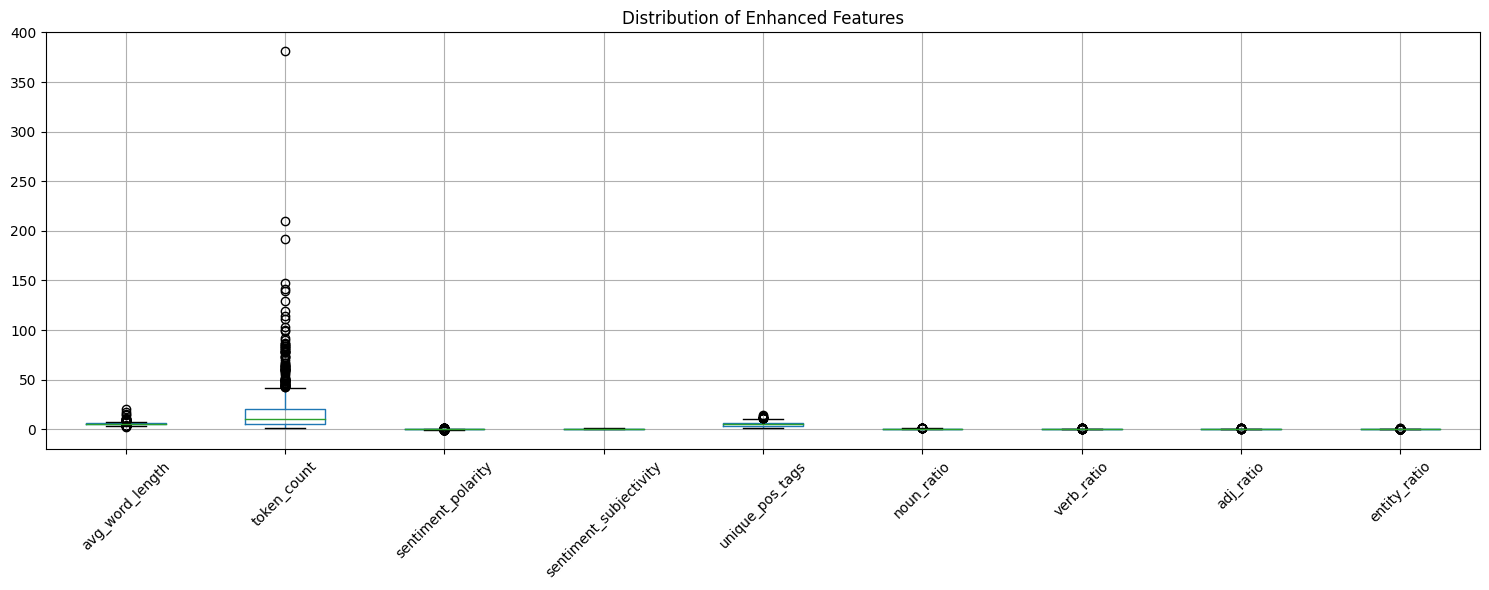

In [24]:
# Part 14: Enhanced Feature Engineering and Analysis

# Standard imports
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setup project paths
notebook_path = Path().resolve()
PROJECT_ROOT = notebook_path.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Current working directory: {notebook_path}")
print(f"Project root: {PROJECT_ROOT}")

# Verify NLTK data
import nltk
print("Verifying NLTK data...")
for resource in ['punkt', 'stopwords']:
    try:
        nltk.data.find(f'tokenizers/{resource}' if resource == 'punkt' else f'corpora/{resource}')
        print(f"√ {resource} already downloaded")
    except LookupError:
        print(f"Downloading {resource}...")
        nltk.download(resource, quiet=True)
print("\nNLTK resources verified!")

# Import our features module
try:
    from src.features.enhanced_features import (
        EnhancedFeatureExtractor,
        calculate_feature_importance,
        analyze_feature_stability,
        analyze_cross_category_interactions
    )
    print("Successfully imported feature extraction modules")
except Exception as e:
    print(f"Error importing modules: {str(e)}")
    raise

# Initialize feature extractor
print("\nInitializing feature extractor...")
extractor = EnhancedFeatureExtractor()

# Load and process data
print("\nLoading processed data...")
data_path = PROJECT_ROOT / 'data/processed/processed_data.pkl'
df = pd.read_pickle(data_path)
print(f"Loaded DataFrame with shape: {df.shape}")

# Extract features
print("\nExtracting enhanced features...")
total_texts = len(df)
enhanced_features = []

for i, text in enumerate(df['processed_text']):
    if i % 100 == 0:
        print(f"Processing text {i}/{total_texts}")
    try:
        features = extractor.extract_enhanced_features(text)
        enhanced_features.append(features)
    except Exception as e:
        print(f"Error processing text {i}: {str(e)}")
        enhanced_features.append(extractor._get_empty_features())

# Create DataFrame and display statistics
enhanced_features_df = pd.DataFrame(enhanced_features)
print("\nFeature Statistics:")
with pd.option_context('display.float_format', '{:.3f}'.format):
    display(enhanced_features_df.describe())

# Save enhanced features
output_path = PROJECT_ROOT / 'data/processed/enhanced_features.pkl'
enhanced_features_df.to_pickle(output_path)
print(f"\nEnhanced features saved to {output_path}")

# Visualize feature distributions
plt.figure(figsize=(15, 6))
enhanced_features_df.boxplot()
plt.xticks(rotation=45)
plt.title('Distribution of Enhanced Features')
plt.tight_layout()
plt.show()

# Define toxic categories
TOXIC_CATEGORIES = [
    'IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative',
    'IsObscene', 'IsHatespeech', 'IsRacist'
]

In [29]:
# Cell 1: Imports and Setup
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif  # Added this import
from sklearn.preprocessing import StandardScaler  # Added for scaling

# Load the enhanced features we just saved
enhanced_features_df = pd.read_pickle(PROJECT_ROOT / 'data/processed/enhanced_features.pkl')

TOXIC_CATEGORIES = [
    'IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative',
    'IsObscene', 'IsHatespeech', 'IsRacist'
]

In [32]:
# Cell 2: Feature Stability Analysis
print("Analyzing feature stability...")

# Create stability matrix using the features we already have
feature_names = enhanced_features_df.columns.tolist()
stability_matrix = pd.DataFrame(
    index=TOXIC_CATEGORIES,
    columns=feature_names,
    dtype=float
)

# Calculate importance scores
for category in TOXIC_CATEGORIES:
    importance_scores = mutual_info_classif(
        enhanced_features_df,
        df[category],
        random_state=42
    )
    stability_matrix.loc[category] = importance_scores

print("\nFeature Stability Scores:")
display(stability_matrix)


Analyzing feature stability...

Feature Stability Scores:


avg_word_length  token_count  sentiment_polarity   
IsToxic               0.002244     0.004545            0.058135  \
IsAbusive             0.000000     0.000000            0.056480   
IsThreat              0.003035     0.000573            0.009163   
IsProvocative         0.000821     0.009251            0.006438   
IsObscene             0.000000     0.011204            0.029223   
IsHatespeech          0.000000     0.031547            0.000779   
IsRacist              0.000000     0.022390            0.006248   

               sentiment_subjectivity  unique_pos_tags  noun_ratio   
IsToxic                      0.000000         0.000000    0.000000  \
IsAbusive                    0.000000         0.000000    0.000000   
IsThreat                     0.013977         0.000000    0.000000   
IsProvocative                0.007447         0.004693    0.000000   
IsObscene                    0.003683         0.002938    0.013469   
IsHatespeech                 0.023607         0.000000    0.018687   
IsRacist                     0.021104         0.000000    0.025643   

               verb_ratio  adj_ratio  entity_ratio  
IsToxic          0.030367   0.000000      0.000000  
IsAbusive        0.022797   0.000000      0.010542  
IsThreat         0.000000   0.000000      0.000000  
IsProvocative    0.014389   0.004389      0.000000  
IsObscene        0.007419   0.018402      0.001656  
IsHatespeech     0.007259   0.019164      0.000000  
IsRacist         0.008262   0.018206      0.000590

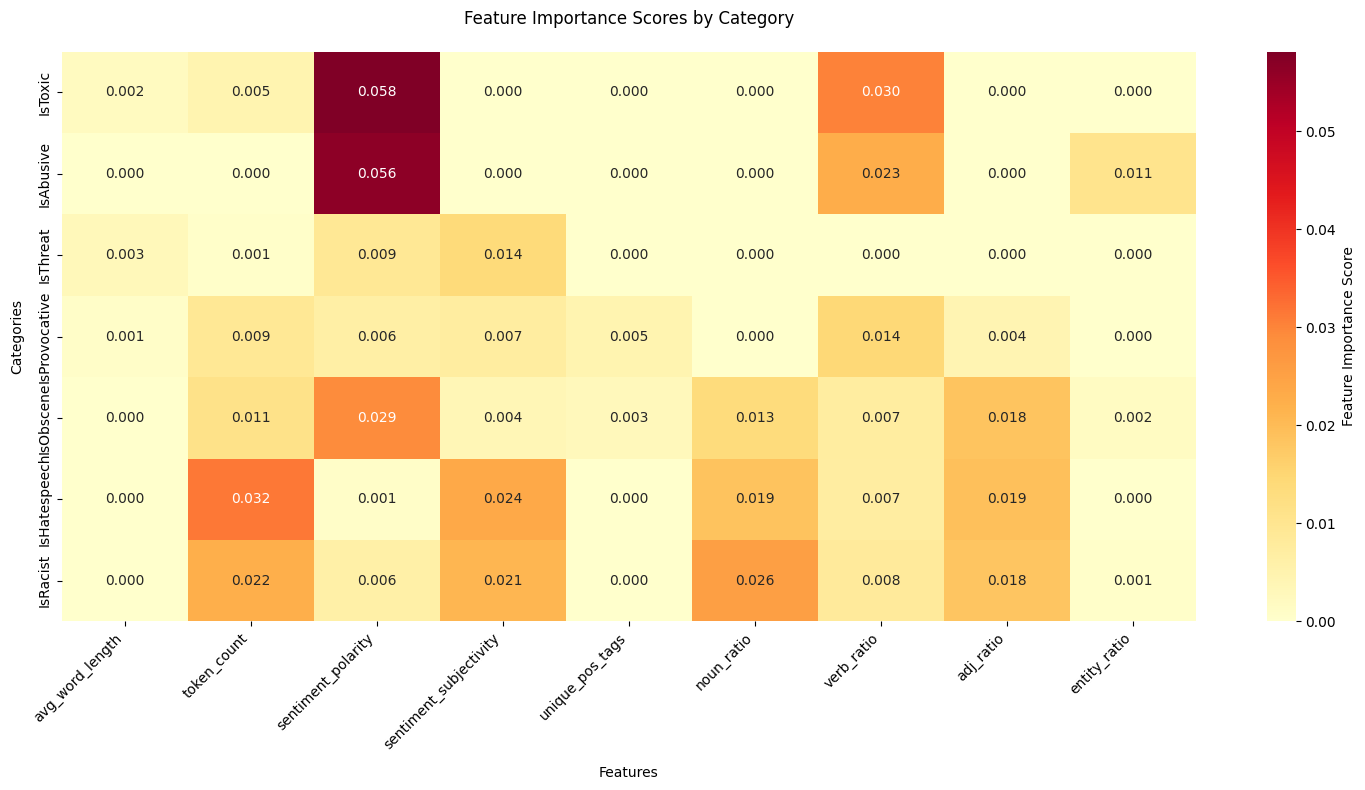

In [33]:
# Cell 3: Feature Importance Visualization
plt.figure(figsize=(15, 8))
sns.heatmap(stability_matrix,
            annot=True,
            fmt='.3f',
            cmap='YlOrRd',
            center=None,
            vmin=0,
            cbar_kws={'label': 'Feature Importance Score'})

plt.title('Feature Importance Scores by Category', pad=20)
plt.xlabel('Features', labelpad=10)
plt.ylabel('Categories', labelpad=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




Analyzing category interactions...

Category Interaction Scores:


IsToxic  IsAbusive  IsThreat  IsProvocative  IsObscene   
IsToxic            NaN   0.764069  0.045455       0.348485   0.216450  \
IsAbusive          1.0        NaN  0.059490       0.456091   0.283286   
IsThreat           1.0   1.000000       NaN       0.428571   0.000000   
IsProvocative      1.0   1.000000  0.055901            NaN   0.161491   
IsObscene          1.0   1.000000  0.000000       0.260000        NaN   
IsHatespeech       1.0   0.210145  0.021739       0.094203   0.079710   
IsRacist           1.0   0.200000  0.008000       0.088000   0.072000   

               IsHatespeech  IsRacist  
IsToxic            0.298701  0.270563  
IsAbusive          0.082153  0.070822  
IsThreat           0.142857  0.047619  
IsProvocative      0.080745  0.068323  
IsObscene          0.110000  0.090000  
IsHatespeech            NaN  0.905797  
IsRacist           1.000000       NaN

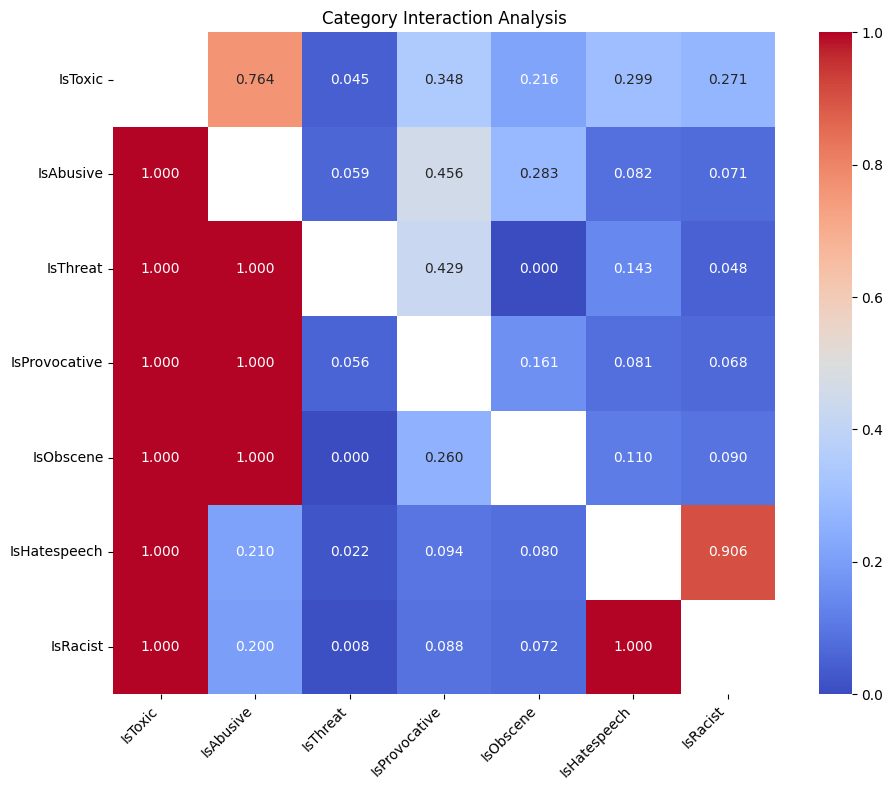


Analysis results saved to /Users/jyajuber/Factoriaf5/Proyecto_NLP/data/processed/feature_analysis.pkl


In [34]:
# Cell 4: Category Interactions
print("\nAnalyzing category interactions...")
interaction_matrix = pd.DataFrame(
    index=TOXIC_CATEGORIES,
    columns=TOXIC_CATEGORIES,
    dtype=float
)

# Calculate category interactions using the original df
for cat1 in TOXIC_CATEGORIES:
    for cat2 in TOXIC_CATEGORIES:
        if cat1 != cat2:
            # Calculate conditional probability P(cat2|cat1)
            mask_cat1 = df[cat1] == 1
            if mask_cat1.sum() > 0:
                prob = (df.loc[mask_cat1, cat2] == 1).mean()
            else:
                prob = 0.0
            interaction_matrix.loc[cat1, cat2] = prob

print("\nCategory Interaction Scores:")
display(interaction_matrix)

# Visualize category interactions
plt.figure(figsize=(10, 8))
sns.heatmap(interaction_matrix,
            annot=True,
            fmt='.3f',
            cmap='coolwarm',
            center=0.5,
            vmin=0,
            vmax=1,
            square=True)
plt.title('Category Interaction Analysis')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Save the analysis results
analysis_results = {
    'stability_scores': stability_matrix,
    'category_interactions': interaction_matrix,
    'timestamp': pd.Timestamp.now()
}

analysis_path = PROJECT_ROOT / 'data/processed/feature_analysis.pkl'
pd.to_pickle(analysis_results, analysis_path)
print(f"\nAnalysis results saved to {analysis_path}")